
# Week 5 - Discovering Patterns: Clusters & Topics

This week, we seek to discover patterns in our text data. First, we take a text corpus that we have developed and discovery emergent clusters through a process known as **clustering** or **partitioning**. We pilot this here both with a well-known *flat* clustering method, `kmeans`, and also a *hierarchical* approach, `Ward's (minimum variance) method`. We will demonstrate a simple (graphical) approach to identifying optimal cluster number, the sillhouette method, and evaluate the quality of unsupervised clusters on labeled data. Next, we will explore a method of two dimensional content clustering called **topic modeling** (e.g., words cluster in topics; topics cluster in documents). This statistical technique models computationally induces *topics* from data, which are sparse distributions over (nonexclusive clusters of) words, from which documents can formally be described as sparse mixtures. We will explore these topics and consider their utility for understanding trends within a corpus. We will consider how to construct models that take document cluster and topic loadings as predictive features, the basis of influence metrics and dynamically over time.

For this notebook we will be using the following packages:

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

import warnings
warnings.filterwarnings("ignore")

Cell 1:

## <span style="color:red">*Pitch Your Project*</span>

<span style="color:red">In the three cells immediately following, describe **WHAT** you are planning to analyze for your final project (i.e., texts, contexts and the social game, world and actors you intend to learn about through your analysis) (<200 words), **WHY** you are going to do it (i.e., why would theory and/or the average person benefit from knowing the results of your investigation) (<200 words), and **HOW** you plan to investigate it (i.e., what are the approaches and operations you plan to perform, in sequence, to yield this insight) (<400 words).

Cell 2:

# ***What?*** 
<200 words

Cell 3:

## ***Why?***
<200 words

Cell 4:

## ***How?***
<400 words

Cell 5:

## <span style="color:red">*Pitch Your Sample*</span>

<span style="color:red">In the cell immediately following, describe the rationale behind your proposed sample design for your final project. What is the social game, social work, or social actors you about whom you are seeking to make inferences? What are its virtues with respect to your research questions? What are its limitations? What are alternatives? What would be a reasonable path to "scale up" your sample for further analysis (i.e., high-profile publication) beyond this class? (<300 words).

Cell 6:

## ***Which (words)?***
<300 words

## What?

By performing computational content analysis on political speeches from all U.S. presidents, from the First Inaugural Address by George Washington to the latest White House press conference on the coronavirus delivered by Donald Trump, my project aims to **reveal official U.S. perception towards China**. I wish to interrogate how the relations between the U.S. and China evolve over time. Specifically, research questions such as how the main topics on the agenda have changed and how positive and/or negative attitudes have altered will be taken into consideration. Furthermore, I hope to discover whether there is a major difference within stances towards China between Democratic and Republican presidents by examining their presidential speeches.


## Why?

The dynamics of U.S. presidential preception towards China not only helps to disclose the political relations between the superpower, the U.S., and one of the world powers, China, but also facilitates people to comprehend the U.S. diplomatic policies as time went by.

Theoretically, few existing political science studies employed quantitative methods to investigate the dynamics of U.S.-China relations. In addition, papers are more focused on a media-centered perspective ([such as Chen, Xi, and Garcia, Francisco X., 2016](https://search.proquest.com/docview/1833248134?pq-origsite=gscholar)), which might not accurately shed light on the changes in the U.S. official tones. Therefore, I hope this project can make up with the gap between quantitative and qualitative analysis, and bridge the studies between official and unofficial U.S. descriptions of China.

Practically, the U.S.-China relation plays an indispensable role in the general public's everyday life. For example, due to Trump's tough anti-globalization attitude, the high-tariff on Chinese goods policies have halted the process of trade liberalization and have left a negative influence on Chinese international trade practitioners. Hence, a deeper understanding of the U.S.-China relations becomes beneficial to guide the assessment of political risks on life.

## How?

As mentioned in the previous assignment, the U.S. presidential speech corpora were constructed by dynamically web crawling documents on [Miller Center](https://millercenter.org/the-presidency/presidential-speeches). Since the project pays attention to the dynamics of U.S.-China relations hidden behind the presidential speeches, the next step is to filter out those discourse that are not relevant to the research question. After obtaining all the speeches needed, I propose to apply techniques from previous notebooks to explore the linguistic characteristics of constructed corpora. Specifically, this includes but not limited to the following:

- Examine the complexity or the richness of wording and sentence structures used by the successive U.S. presidents. In particular, I will dive into the difference between Democratic and Republican leaders.
- Perform sentiment classification of the speeches to show the positive or negative attitudes towards China using pre-labeled samples.
- Implement clustering analysis and topic modeling to categorize the topics in the presidential speeches, which serves as a significant part of the study. Furthermore, based on the date a particular speech was addressed, perform dynamic topic modeling to figure out the evolvement of the important topics on the agenda.
- Other computational content analysis that employs natural language processing techniques in the next few weeks.

## Which?

The social work is the presidential speeches addressed by all the U.S. presidents from George Washington to Donald Trump and the social actors are the U.S. presidents as mentioned above. Since the project intends to investigate the U.S.-China relations, not all discourses are of research interest. I try to sample China-related speeches by searching the relevant keywords such as "China", "Chinese" and etc. A rough count shows that there are 213 pieces of speeches that can be utilized for supporting analysis, thus I have sufficient data to perform the research. With the first China-related speech China-related speech delivered by John Adams on December 6, 1825, and the latest one spoken by Donald Trump on March 13, 2020, the chosen samples cross over a relatively wide time span which is conducive to dynamic time-series analysis.

With that being said, the president's attitudes towards China can be disclosed further by studying their social media such as Tweets, which contributes to the limitation of the project, especially given that the remarks on social platforms might possess much broader and far-reaching effects nowadays. For robustness, it is reasonable to "scale up" the sample by including the presidents' speeches on social platforms in the future analysis.

# Getting our corpora

To begin, we will use a well known corpus of testing documents from the *20 Newsgroups corpus*, a dataset commonly used to illustrate text applications of text clustering and classification. This comes packaged with sklearn and comprises approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 newsgroups. It was originally collected by Ken Lang, probably for his 1995 *Newsweeder: Learning to filter netnews* paper. The data is organized into 20 distinct newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related (e.g. comp.sys.ibm.pc.hardware / comp.sys.mac.hardware), while others are unrelated (e.g misc.forsale / soc.religion.christian). 

In [2]:
newsgroups = sklearn.datasets.fetch_20newsgroups(subset='train', data_home ='../data/scikit_learn_data')
print(dir(newsgroups))

['DESCR', 'data', 'filenames', 'target', 'target_names']


We can ascertain the categories with `target_names` or the actual files with `filenames`

In [3]:
print(newsgroups.target_names)
print(len(newsgroups.data))

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
11314


We will start by converting the provided data into pandas DataFrames.

First we reduce our dataset for this analysis by dropping some extraneous information and converting it into a DataFrame.

In [4]:
newsgroupsCategories = ['comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos']

newsgroupsDF = pandas.DataFrame(columns=['text', 'category', 'source_file'])

for category in newsgroupsCategories:
    print("Fetching data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(subset='train', categories=[category], remove=['headers', 'footers', 'quotes'], data_home='../data/scikit_learn_data/')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text': ng.data, 'category': [category] * len(ng.data), 'source_file': ng.filenames}), ignore_index=True)

#Creating an explicit index column for later

#newsgroupsDF['index'] = range(len(newsgroupsDF))
#newsgroupsDF.set_index('index', inplace = True)
print(len(newsgroupsDF))
newsgroupsDF[:10]

Fetching data for: comp.sys.mac.hardware
Fetching data for: comp.windows.x
Fetching data for: misc.forsale
Fetching data for: rec.autos
2350


,text,category,source_file
0,"\tIn certain Apple 13"" RGB monitors there has ...",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
1,Does anyone know how to reach Micron? I am in...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
2,Hi there!\n\nCould some kind soul tell me what...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
3,"""auto\nfrom",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
4,\n\n Don't believe the hype. There is no su...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
5,What is the value of an SE (HDFD) 4/20?\n\n-David,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
6,\n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
7,"\n\n\n Nope. The Apple 16"" monitor does not...",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
8,\n\nIs it a hidden option? I'm using PowerStr...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
9,\n\n\nThe previous article referred to the fac...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...


Next, we can convert the documents into **word count vectors** (e.g., *soc.religion.christian message a* might contain 3 mentions of "church", 2 of "jesus", 1 of "religion", etc., yielding a CountVector=[3,2,1,...])

In [5]:
#First it needs to be initialized
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
newsgroupsVects = ngCountVectorizer.fit_transform(newsgroupsDF['text'])
print(newsgroupsVects.shape)

(2350, 23525)


This gives us a matrix with row a document and each column a word. The matrix is mostly zeros, so we store it as a sparse matrix, a data structure that contains and indexes only the nonzero entries.

In [6]:
newsgroupsVects

<2350x23525 sparse matrix of type '<class 'numpy.int64'>'
	with 177750 stored elements in Compressed Sparse Row format>

We can use the normal operations on this sparse matrix or convert it to normal matrix (not recommended for large sparse matrices :-)

In [7]:
newsgroupsVects[:10,:20].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

We can also lookup the indices of different words using the Vectorizer

In [8]:
ngCountVectorizer.vocabulary_.get('vector')

21647

There are some more interesting things to do...

Lets start with [term frequency–inverse document frequency](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)(tf-idf), a method for weighting document-distinguishing words.

In [9]:
#initialize
newsgroupsTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(newsgroupsVects)
#train
newsgroupsTF = newsgroupsTFTransformer.transform(newsgroupsVects)
print(newsgroupsTF.shape)

(2350, 23525)


This gives us the tf-idf for each word in each text

In [10]:
list(zip(ngCountVectorizer.vocabulary_.keys(), newsgroupsTF.data))[:20]

[('in', 0.08265545268171724),
 ('certain', 0.05464092321093494),
 ('apple', 0.19706119834212132),
 ('13', 0.05749878121929968),
 ('rgb', 0.07820822067701588),
 ('monitors', 0.0749569030656185),
 ('there', 0.10567912764152107),
 ('has', 0.1109950967372947),
 ('been', 0.05330795380898169),
 ('problem', 0.21470375597395805),
 ('with', 0.09901319943986409),
 ('the', 0.19389877721110985),
 ('high', 0.1817286448065436),
 ('voltage', 0.19389877721110985),
 ('capasitor', 0.33279218254193177),
 ('knows', 0.18819404816424326),
 ('about', 0.08243502153417578),
 ('this', 0.1619412292430009),
 ('and', 0.13074268623716792),
 ('is', 0.16299450361806797)]

At first glance, there appears to be a lot of garbage littering this unordered list with unique words and stopwords. Note, however, that words like *apple*, *rgb*, and *voltage* distinguish this newsgroup document, while stopwords post a much lower weight. Note that we could filter out stop words, stem and lem our data before vectorizering, or we can instead use tf-idf to filter our data (or **both**). For exact explanation of all options look [here](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). To prune this matrix of features, we now limit our word vector to **1000 words with at least 3 occurrences**, which do not occur in more than half of the documents. There is an extensive science and art to feature engineering for machine learning applications like clustering.

In [11]:
#initialize
ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
newsgroupsTFVects = ngTFVectorizer.fit_transform(newsgroupsDF['text'])

Lets look at the matrix

In [12]:
newsgroupsDF['text']

0       \tIn certain Apple 13" RGB monitors there has ...
1       Does anyone know how to reach Micron?  I am in...
2       Hi there!\n\nCould some kind soul tell me what...
3                                             "auto\nfrom
4       \n\n    Don't believe the hype. There is no su...
                              ...                        
2345    I was wondering if anyone out in net-land have...
2346    \n\n\n\n\nI sold my '86 Sprint last April with...
2347    Actually I wasn't too surprised, since I bough...
2348    \n\nI couldnt agree more.  That is how it SHOU...
2349    \nWarren Brown, the Washington Post's auto wri...
Name: text, Length: 2350, dtype: object

The matrix is much smaller now, only 1000 words, but the same number of documents

We can still look at the words:

In [13]:
try:
    print(ngTFVectorizer.vocabulary_['vector'])
except KeyError:
    print('vector is missing')
    print('The available words are: {} ...'.format(list(ngTFVectorizer.vocabulary_.keys())[:10]))

vector is missing
The available words are: ['certain', 'apple', '13', 'monitors', 'problem', 'high', 'cost', 'bad', 'got', 'local'] ...


This is a reasonable matrix of features with which to begin identifying clusters.

# Flat Clustering with $K$-means

Lets start with $k$-means, an approach that begins with random clusters of predefined number, then iterates cluster reassignment and evaluates the new clusters relative to an objective function, recursively.

To do this we will need to know how many clusters we are looking for. Here the *true number* of clusters is 4. Of course, in most cases you would not know the number in advance.

In [14]:
numClusters = len(set(newsgroupsDF['category']))
numClusters

4

Then we can initialize our cluster finder

In [15]:
#k-means++ is a better way of finding the starting points
#We could also try providing our own
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')

And now we can calculate the clusters

In [16]:
km.fit(newsgroupsTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Once we have the clusters, we can evaluate them with a variety of metrics that sklearn provides. We will look at a few, including *Homogeneity*, *Completeness*, *V-measure* and *Adjusted Rand Score*. 

*Homogeneity* is a measure that grows (from 0 to 1) to the degree that all of its clusters contain only data points which are members of a single class (e.g., newsgroup). 

*Completeness* is *Homogeneity's* converse: a measure that grows (0 to 1) to the degree that all data points of a given class are also elements of the same cluster.

The *V-measure* is the harmonic mean of *Homogeniety* and *Completeness* ($v = 2 * (homogeneity * completeness) / (homogeneity + completeness$).

The *Adjusted Rand Score* is built atop the *Rand Index (RI)*, which computes the similarity between two clusterings by considering all pairs of samples and counting pairs assigned in the same or different clusters in the predicted and true clusterings (e.g., actual newsgroups). The *RI* is then adjusted for chance as follows:
$ARI = (RI - RI_{expected}) / (max(RI) - RI_{expected})$.
The Adjusted Rand Index is thus ensured to have a value close to 0.0 for random labeling independent of the number of clusters and samples, 1.0 when the clusterings are identical, and -1.0 when they are as bad (i.e., cross-cutting) as they can be.

In [17]:
print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("\nFor our clusters:")
print("\nHomogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], km.labels_)))
print("\nCompleteness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], km.labels_)))
print("\nV-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], km.labels_)))
print("\nAdjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], km.labels_)))

The available metrics are: ['ConfusionMatrixDisplay', 'PrecisionRecallDisplay', 'RocCurveDisplay', 'SCORERS', 'accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'auc', 'average_precision_score', 'balanced_accuracy_score', 'brier_score_loss', 'calinski_harabasz_score', 'calinski_harabaz_score', 'check_scoring', 'classification_report', 'cluster', 'cohen_kappa_score', 'completeness_score', 'confusion_matrix', 'consensus_score', 'coverage_error', 'davies_bouldin_score', 'dcg_score', 'euclidean_distances', 'explained_variance_score', 'f1_score', 'fbeta_score', 'fowlkes_mallows_score', 'get_scorer', 'hamming_loss', 'hinge_loss', 'homogeneity_completeness_v_measure', 'homogeneity_score', 'jaccard_score', 'jaccard_similarity_score', 'label_ranking_average_precision_score', 'label_ranking_loss', 'log_loss', 'make_scorer', 'matthews_corrcoef', 'max_error', 'mean_absolute_error', 'mean_gamma_deviance', 'mean_poisson_deviance', 'mean_squared_error', 'mean_squared_log_error', '

You can evaluate these for different clustering solutions ($1-N$ clusters). You can also interrogate the alignment between specific documents and their cluster assignments by adding the cluster labels to the pandas dataframe.

In [18]:
newsgroupsDF['kmeans_predictions'] = km.labels_
newsgroupsDF

,text,category,source_file,kmeans_predictions
0,"\tIn certain Apple 13"" RGB monitors there has ...",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0
1,Does anyone know how to reach Micron? I am in...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0
2,Hi there!\n\nCould some kind soul tell me what...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0
3,"""auto\nfrom",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0
4,\n\n Don't believe the hype. There is no su...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0
...,...,...,...,...
2345,I was wondering if anyone out in net-land have...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,0
2346,\n\n\n\n\nI sold my '86 Sprint last April with...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,2
2347,"Actually I wasn't too surprised, since I bough...",rec.autos,../data/scikit_learn_data/20news_home/20news-b...,2
2348,\n\nI couldnt agree more. That is how it SHOU...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,0


We can also look at the distinguishing features in each cluster:

In [19]:
terms = ngTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 know
 thanks
 mac
 just
 does
 drive
 apple
 like
 don
 problem


Cluster 1:
 window
 server
 use
 motif
 using
 widget
 program
 application
 like
 code


Cluster 2:
 car
 cars
 engine
 like
 just
 good
 think
 don
 dealer
 new


Cluster 3:
 sale
 00
 offer
 shipping
 condition
 new
 asking
 sell
 interested
 price




Let's construct **a visualization of the clusters**. 

First, we will first reduce the dimensionality of the data using **principal components analysis (PCA)**.

In [20]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components=2).fit(newsgroupsTFVects.toarray())
reduced_data = pca.transform(newsgroupsTFVects.toarray())

The cell below is optional. It allows you to do a biplot

In [21]:
components = pca.components_
#Get the ids of the most distinguishing words(features) from your kmeans model.
keyword_ids = list(set(order_centroids[:,:10].flatten()))
#Turn the ids into words.
words = [terms[i] for i in keyword_ids]
#Find the coordinates of those words in your biplot.
x = components[:,keyword_ids][0,:] 
y = components[:,keyword_ids][1,:]

Then, let's build a color map for the true labels.

In [22]:
colordict = {
    'comp.sys.mac.hardware': 'red',
    'comp.windows.x': 'orange',
    'misc.forsale': 'green',
    'rec.autos': 'blue',
    }
colors = [colordict[c] for c in newsgroupsDF['category']]
print("The categories' colors are:\n{}".format(colordict.items()))

The categories' colors are:
dict_items([('comp.sys.mac.hardware', 'red'), ('comp.windows.x', 'orange'), ('misc.forsale', 'green'), ('rec.autos', 'blue')])


Let's plot the data using the true labels as the colors of our data points.

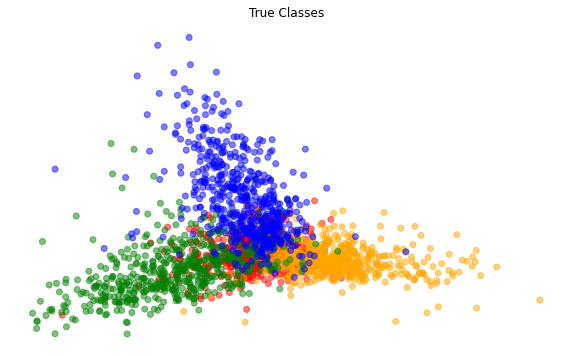

In [23]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color=colors, alpha=0.5, label=colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

One nice thing about PCA is that we can also do a biplot and map our feature
vectors to the same space.

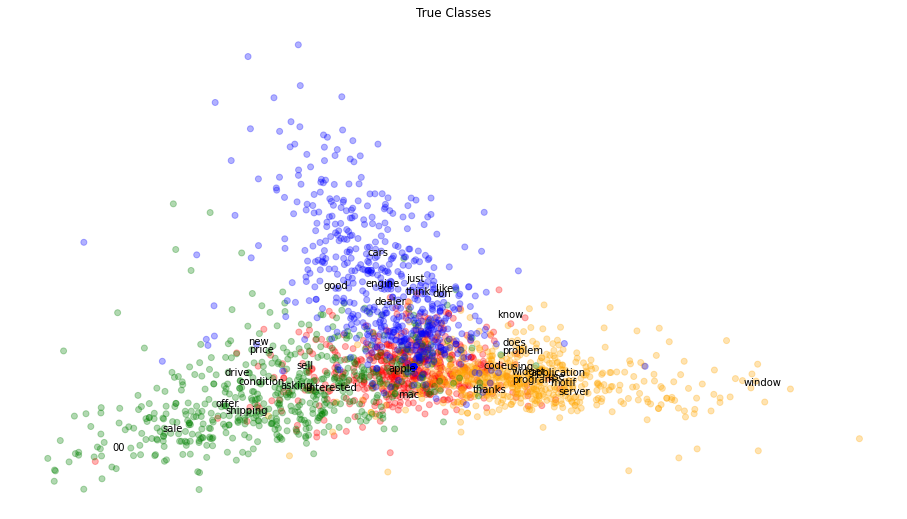

In [24]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color=colors, alpha=0.3, label=colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

Let's do it again with predicted clusters.

In [25]:
colors_p = [colordict[newsgroupsCategories[l]] for l in km.labels_]
print(colors[:10], "\n", colors_p[:10])

['red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red'] 
 ['red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red']


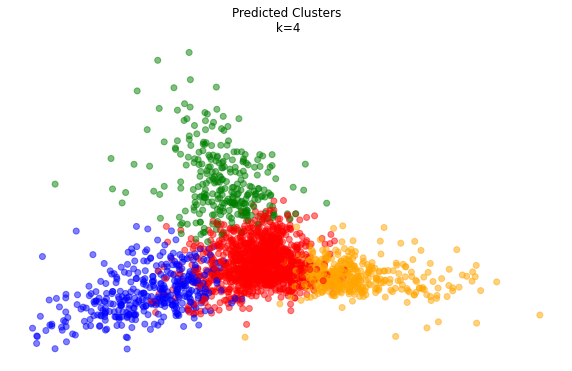

In [26]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color=colors_p, alpha=0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k=4')
plt.show()

Let's try with 3 clusters.

In [27]:
km3 = sklearn.cluster.KMeans(n_clusters=3, init='k-means++')
km3.fit(newsgroupsTFVects.toarray())

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# Selecting Cluster Number

We can select an optimal cluster number by identifying the lowest of the metrics listed above (e.g., V-measure), but often you don't have "ground truth" or labeled data. For identifying the "best" number of clusters in an unsupervised way, we demonstrate **the Silhouette method**. Many other methods also exist (e.g., Bayesian Information Criteria or BIC, the visual "elbow criteria", etc.)

First we will define a helper function:

In [28]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels==i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters=%d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

Now we can examine a few different numbers of clusters:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


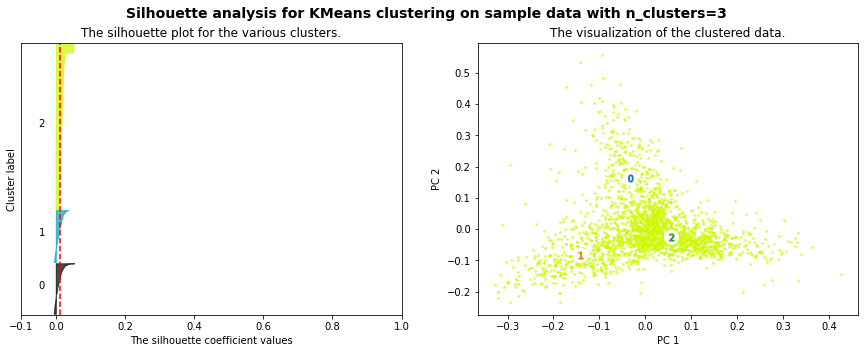

For n_clusters = 3, The average silhouette_score is : 0.013


In [29]:
X = newsgroupsTFVects.toarray()
plotSilhouette(3, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


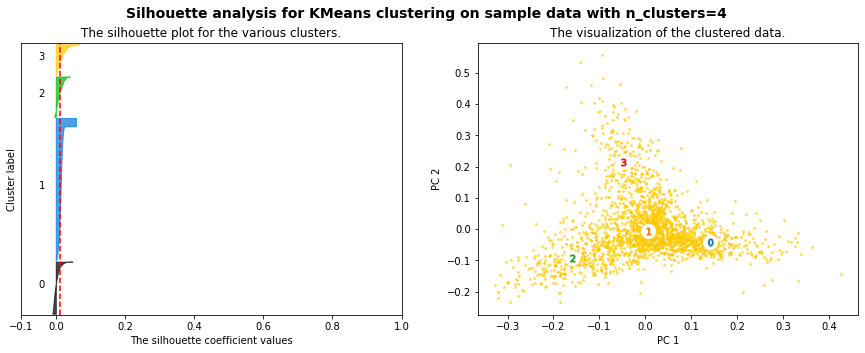

For n_clusters = 4, The average silhouette_score is : 0.012


In [30]:
X = newsgroupsTFVects.toarray()
plotSilhouette(4, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


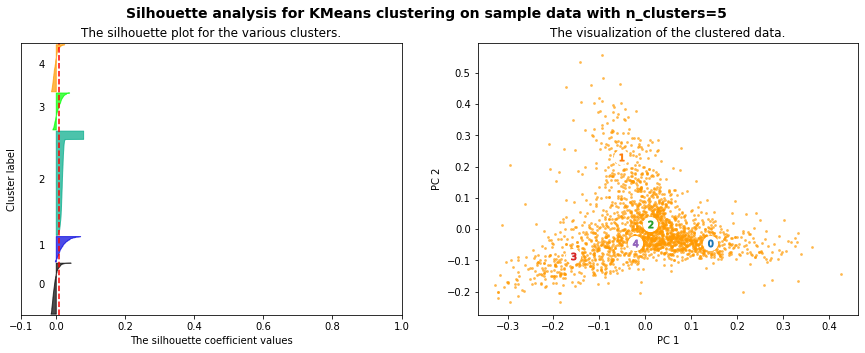

For n_clusters = 5, The average silhouette_score is : 0.010


In [31]:
X = newsgroupsTFVects.toarray()
plotSilhouette(5, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


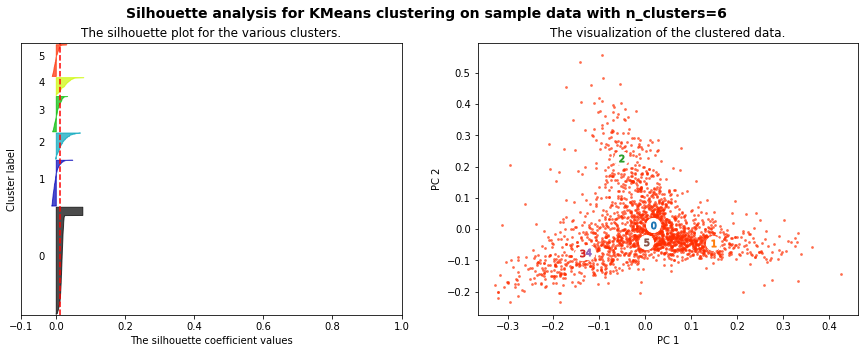

For n_clusters = 6, The average silhouette_score is : 0.011


In [32]:
X = newsgroupsTFVects.toarray()
plotSilhouette(6, X)

Interestingly, the silhouette scores above suggests that 3 is a better number of clusters than 4, which would be accurate if we (reasonsably) grouped the two computer-themed groups together.

# Getting new text data

Lets start by using the same function as last lesson and loading a few press releases from 10 different senators into a DataFrame. The code to do this is below, but commented out as we've already downloaded the data to the data directory.

In [33]:
targetSenator = 'Kennedy'# = ['Voinovich', 'Obama', 'Whitehouse', 'Snowe', 'Rockefeller', 'Murkowski', 'McCain', 'Kyl', 'Baucus', 'Frist']
"""
#Uncomment this to download your own data
senReleasesTraining = pandas.DataFrame()

print("Fetching {}'s data".format(targetSenator))
targetDF = lucem_illud.getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/{}'.format(targetSenator), maxFiles = 2000)
targetDF['targetSenator'] = targetSenator
senReleasesTraining = senReleasesTraining.append(targetDF, ignore_index = True)

#Watch out for weird lines when converting to csv
#one of them had to be removed from the Kennedy data so it could be re-read
senReleasesTraining.to_csv("data/senReleasesTraining.csv")
"""

senReleasesTraining = pandas.read_csv("../data/senReleasesTraining.csv")

senReleasesTraining[:5]

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
1,1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2005Kennedy12.txt,raw/Kennedy/01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
2,2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy10.txt,raw/Kennedy/01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
3,3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy11.txt,raw/Kennedy/01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
4,4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy12.txt,raw/Kennedy/01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy


Now we have the files we can tokenize and normalize.

The normalized text is good, but we know that the texts will have a large amount of overlap so we can use tf-idf to remove some of the most frequent words. Before doing that, there is one empty cell, let's remove that.

In [34]:
senReleasesTraining = senReleasesTraining.dropna(axis=0, how='any')

In [35]:
#Similar parameters to before, but stricter max df and no max num occurrences
senTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
senTFVects = senTFVectorizer.fit_transform(senReleasesTraining['text'])
senTFVectorizer.vocabulary_.get('senat', 'Missing "Senate"')

'Missing "Senate"'

# Clustering with our new data

One nice thing about using DataFrames for everything is that we can quickly convert code from one input to another. Below we are redoing the cluster detection with our senate data. If you setup your DataFrame the same way it should be able to run on this code, without much work.

First we will define what we will be working with

In [36]:
targetDF = senReleasesTraining
textColumn = 'text'
numCategories = 3

Tf-IDf vectorizing

In [37]:
exampleTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
exampleTFVects = ngTFVectorizer.fit_transform(targetDF[textColumn])

Running k means

In [38]:
exampleKM = sklearn.cluster.KMeans(n_clusters=numCategories, init='k-means++')
exampleKM.fit(exampleTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

And visualize:

In [39]:
examplePCA = sklearn.decomposition.PCA(n_components=2).fit(exampleTFVects.toarray())
reducedPCA_data = examplePCA.transform(exampleTFVects.toarray())

colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in exampleKM.labels_]

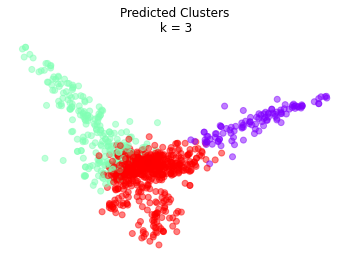

In [40]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], color=colors_p, alpha=0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

In this case, there may be two clusters that could be identified with Silhouette analysis or some of the metrics described above; although not having true classes makes that tricky. Below, we add these cluster assignments to the dataframe for individual perusal and evaluation.

In [41]:
targetDF['kmeans_predictions'] = exampleKM.labels_
targetDF

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator,kmeans_predictions
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,1
1,1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2005Kennedy12.txt,raw/Kennedy/01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,2
2,2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy10.txt,raw/Kennedy/01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1
3,3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy11.txt,raw/Kennedy/01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,2
4,4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy12.txt,raw/Kennedy/01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,2
...,...,...,...,...,...,...,...,...
994,995,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,18Jul2005Kennedy13.txt,raw/Kennedy/18Jul2005Kennedy13.txt,FOR IMMEDIATE RELEASE Department ...,Kennedy,1
995,996,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,18Jul2005Kennedy14.txt,raw/Kennedy/18Jul2005Kennedy14.txt,FOR IMMEDIATE RELEASE I welcome t...,Kennedy,2
996,997,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,18Jul2006Kennedy0.txt,raw/Kennedy/18Jul2006Kennedy0.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,2
997,998,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,18Jul2006Kennedy1.txt,raw/Kennedy/18Jul2006Kennedy1.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,2


## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that construct features and cluster your documents using K-means and a variety of cluster numbers. Interrogate the cluster contents in terms of both documents and features. Identify the "optimal" cluster number with Silhouette analysis. Plot clusters and features after reducing with PCA. What does this cluster structure reveal about the organization of documents in your corpora? 

In [42]:
import pandas as pd

# Load the presidential speech corpora
speech = pd.read_csv("presidential_speeches.csv", index_col=0)
# Remove duplicate index columns
speech.drop(speech.columns[0], axis=1, inplace=True)
speech.sample(10, random_state=25)

,link,title,date,name,source,script
256,https://millercenter.org/the-presidency/presid...,"October 6, 1976: Debate with President Gerald ...","October 06, 1976",Jimmy Carter,National Archives,\nTranscript\nGood evening. I am Pauline Frede...
49,https://millercenter.org/the-presidency/presid...,"October 21, 2011: Remarks on the End of the Wa...","October 21, 2011",Barack Obama,NaN,"\nTranscript\nGood afternoon, everybody. As a..."
224,https://millercenter.org/the-presidency/presid...,"December 23, 1981: Address to the Nation on Ch...","December 23, 1981",Ronald Reagan,Miller Center,\nTranscript\nGood evening.\nAt Christmas time...
838,https://millercenter.org/the-presidency/presid...,"December 8, 1846: Second Annual Message to Con...","December 08, 1846",James K. Polk,(not specified),TranscriptFellow-Citizens of the Senate and of...
344,https://millercenter.org/the-presidency/presid...,"January 4, 1965: State of the Union\n","January 04, 1965",Lyndon B. Johnson,National Archives,"\nTranscript\nMr. Speaker, Mr. President, memb..."
766,https://millercenter.org/the-presidency/presid...,"May 29, 1865: Proclamation Pardoning Persons w...","May 29, 1865",Andrew Johnson,(not specified),TranscriptWhereas the President of the United ...
631,https://millercenter.org/the-presidency/presid...,"December 17, 1895: Message Regarding Venezuela...","December 17, 1895",Grover Cleveland,(not specified),TranscriptTo the Congress:\nIn my annual messa...
1004,https://millercenter.org/the-presidency/presid...,"March 11, 2020: Statement on the Coronavirus\n","March 11, 2020",Donald Trump,The White House,"\nTranscript\nMy fellow Americans: Tonight, I ..."
113,https://millercenter.org/the-presidency/presid...,"May 11, 2001: Proposal for Global Fund to Figh...","May 11, 2001",George W. Bush,George W. Bush Presidential Library and Museum,\nTranscript\nIt is my honor to welcome our fr...
806,https://millercenter.org/the-presidency/presid...,"August 1, 1854: Message Regarding US-Spanish R...","August 01, 1854",Franklin Pierce,(not specified),TranscriptTo the Senate of the United States:\...


In [43]:
len(speech)

1010

In [44]:
# Tokenize and calculate the tf-idf matrix with `max_df=500` and `min_df=5`
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=500, min_df=5, stop_words="english", norm="l2")
speechTFVects = TFVectorizer.fit_transform(speech["script"])

In [45]:
speechTFVects.shape

(1010, 15620)

In [46]:
# Perform k-means clustering
numClusters = 5
km = sklearn.cluster.KMeans(n_clusters=numClusters, init="k-means++")

In [47]:
# Calculate the clusters for speeches
km.fit(speechTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [49]:
# Evaluate by sklearn metrics
print("For the presidential speeches clusters: \n")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(speech["script"], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(speech["script"], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(speech["script"], km.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(speech["script"], km.labels_)))

For the presidential speeches clusters: 

Homogeneity: 0.205
Completeness: 1.000
V-measure: 0.340
Adjusted Rand Score: 0.000


In [50]:
# Check the distinguish features in each cluster
terms = TFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster {}".format(i))
    for ind in order_centroids[i, :10]:
        print(terms[ind])
    print("\n")

Top terms per cluster:
Cluster 0
constitution
laws
treaty
persons
senate
territory
authority
duties
subject
executive


Cluster 1
today
americans
soviet
vietnam
man
forces
help
human
iraq
tonight


Cluster 2
ve
mr
think
tax
going
don
americans
budget
tonight
billion


Cluster 3
000
treasury
department
subject
service
treaty
attention
commerce
revenue
report


Cluster 4
applause
ve
thank
laughter
going
don
jobs
got
ll
americans




In [51]:
# Use PCA to reduce dimensions and visualize in 2-D graphs
speechPCA = sklearn.decomposition.PCA(n_components=2).fit(speechTFVects.toarray())
reduced_speechPCA = speechPCA.transform(speechTFVects.toarray())

colors = list(plt.cm.rainbow(np.linspace(0, 1, numClusters)))
colors_p = [colors[l] for l in km.labels_]

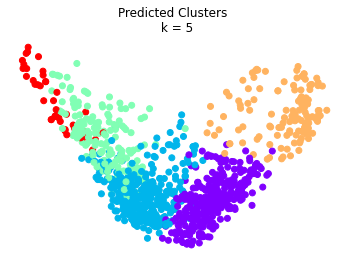

In [52]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_speechPCA[:, 0], reduced_speechPCA[:, 1], color=colors_p)
plt.xticks(())
plt.yticks(())
plt.title("Predicted Clusters \n k = {}".format(numClusters))
plt.show()

In [53]:
# Optimize for the best value for K. 

def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    
    # note:!! pca needs re-configuration
    PCA = sklearn.decomposition.PCA
    pca = PCA(n_components = 2).fit(X)
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


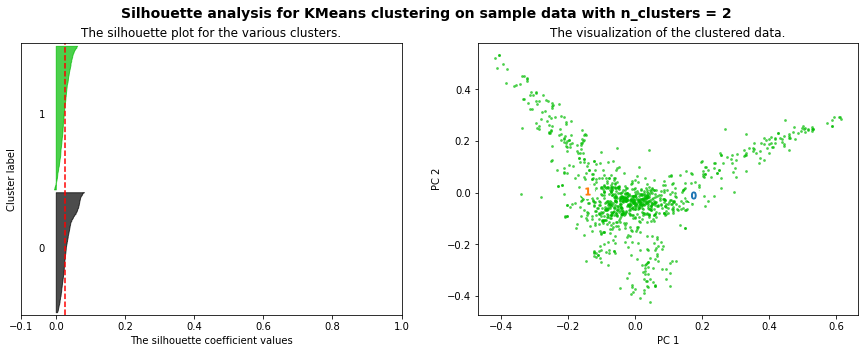

For n_clusters = 2, The average silhouette_score is : 0.028


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


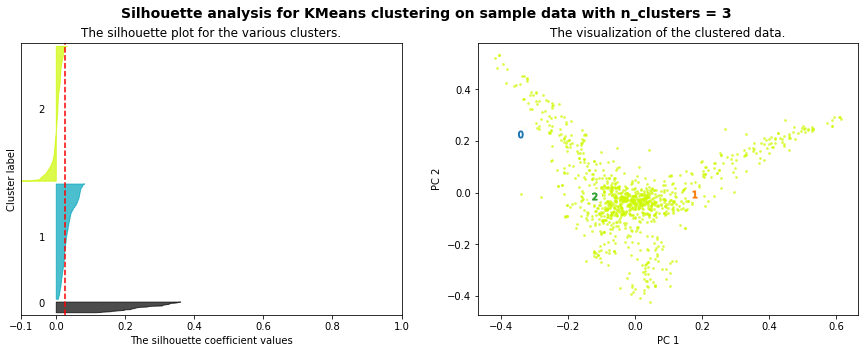

For n_clusters = 3, The average silhouette_score is : 0.026


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


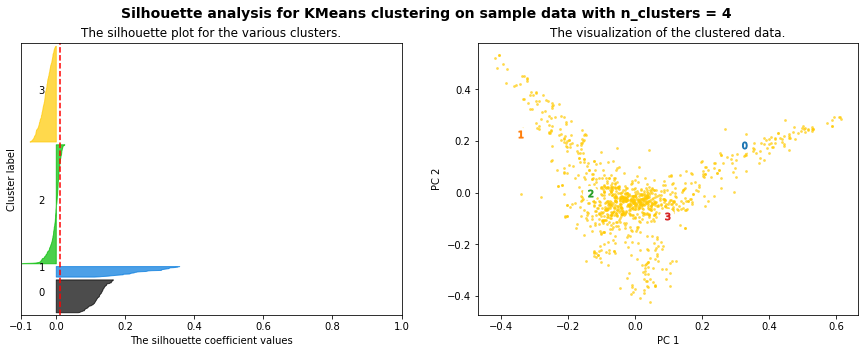

For n_clusters = 4, The average silhouette_score is : 0.013


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


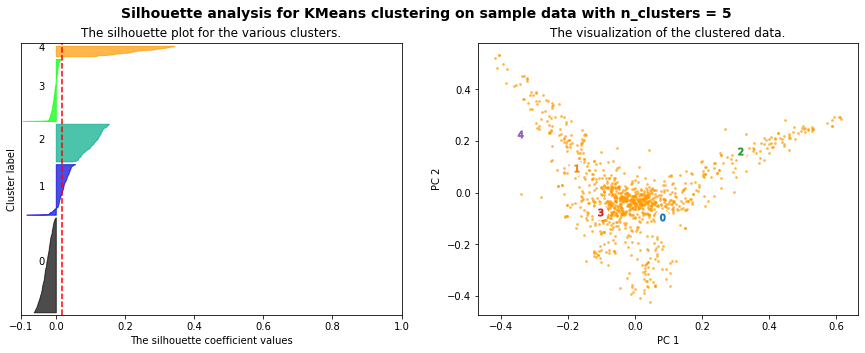

For n_clusters = 5, The average silhouette_score is : 0.017


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


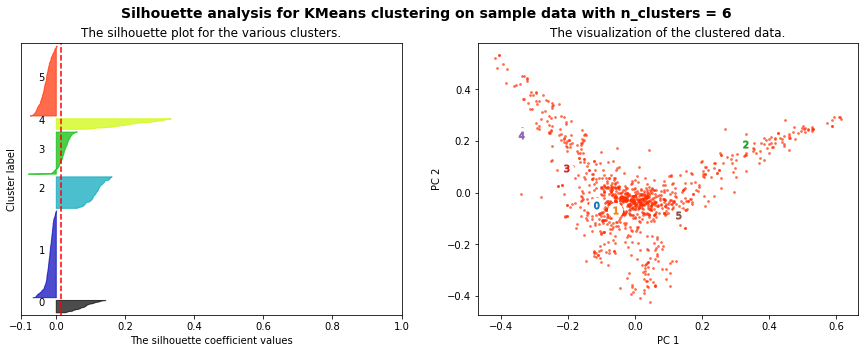

For n_clusters = 6, The average silhouette_score is : 0.016


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


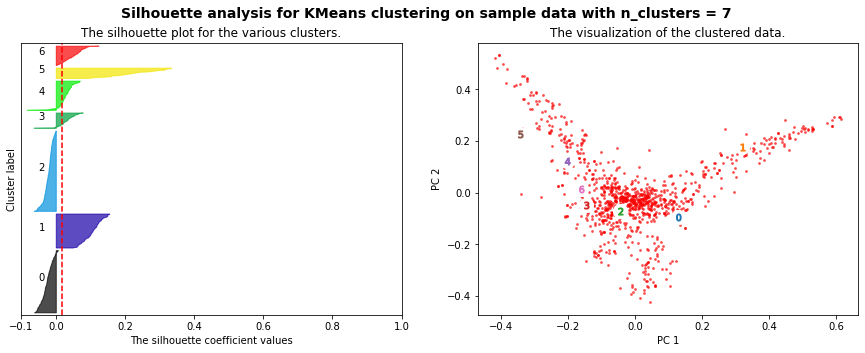

For n_clusters = 7, The average silhouette_score is : 0.019


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


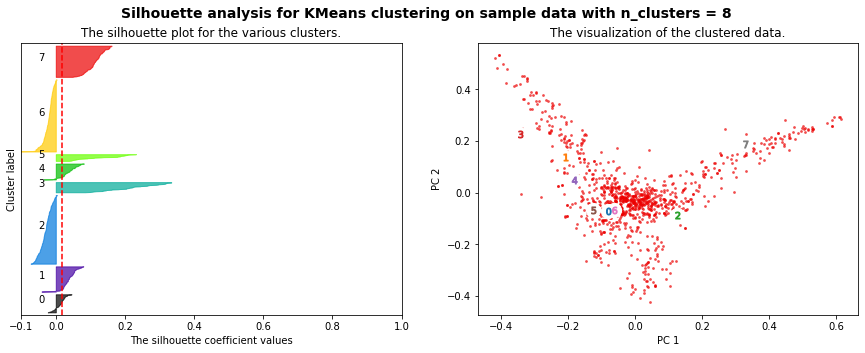

For n_clusters = 8, The average silhouette_score is : 0.019


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


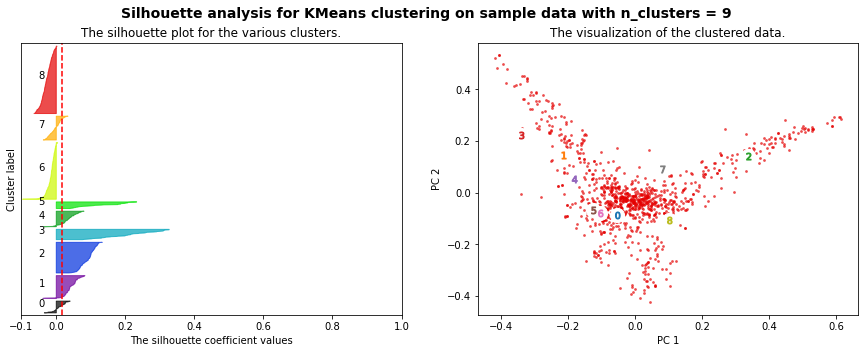

For n_clusters = 9, The average silhouette_score is : 0.019


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


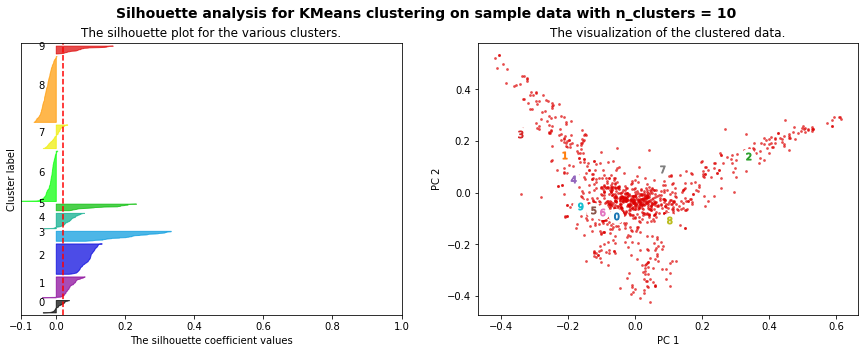

For n_clusters = 10, The average silhouette_score is : 0.021


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


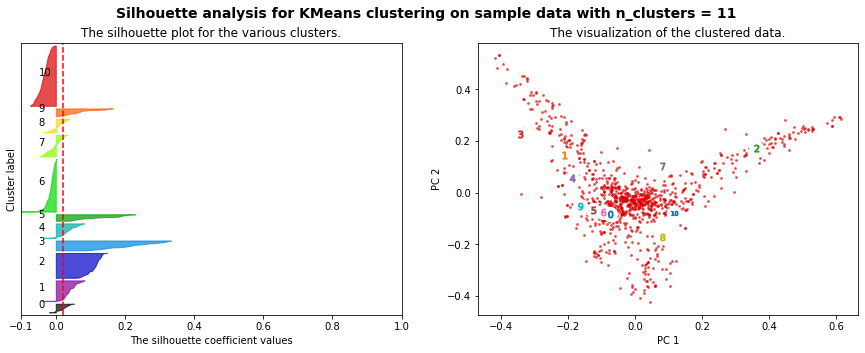

For n_clusters = 11, The average silhouette_score is : 0.020


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


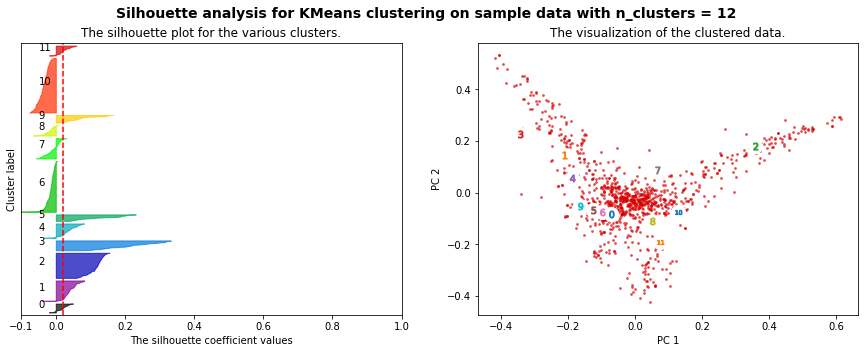

For n_clusters = 12, The average silhouette_score is : 0.020


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


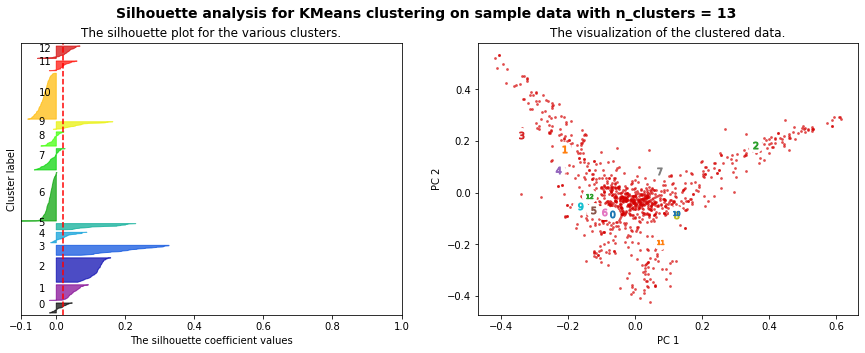

For n_clusters = 13, The average silhouette_score is : 0.020


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


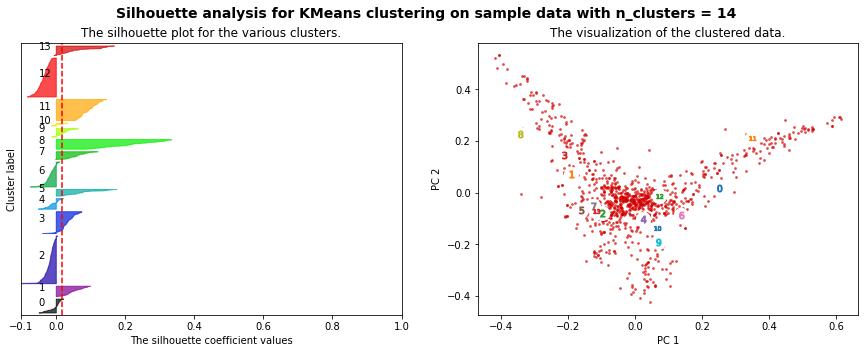

For n_clusters = 14, The average silhouette_score is : 0.018


In [54]:
# Identify the optimal cluster number with Silhouette analysis
for cluster_num in range(2, 15):
    X = speechTFVects.toarray()
    plotSilhouette(cluster_num, X)

For number of clustering ranging from 2 to 14, the average silhouette score first drops from 0.028 to the lowest 0.013 when the number of clusters is 4, then gradually increases to 0.021 with cluster numbers equals to 10, and it continues to decrease with the increase of the number of clusters up to 14.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


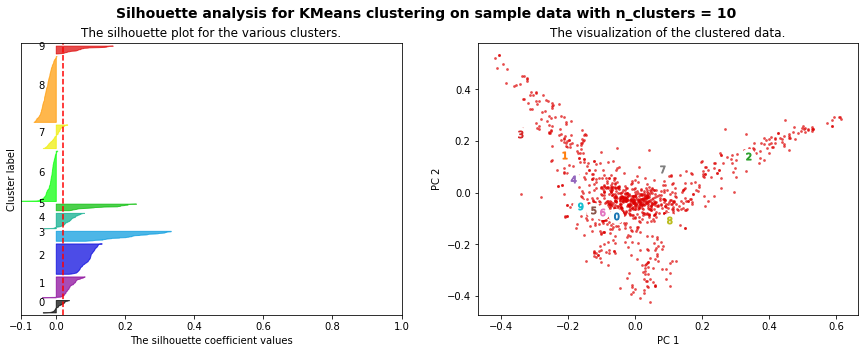

For n_clusters = 10, The average silhouette_score is : 0.021


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


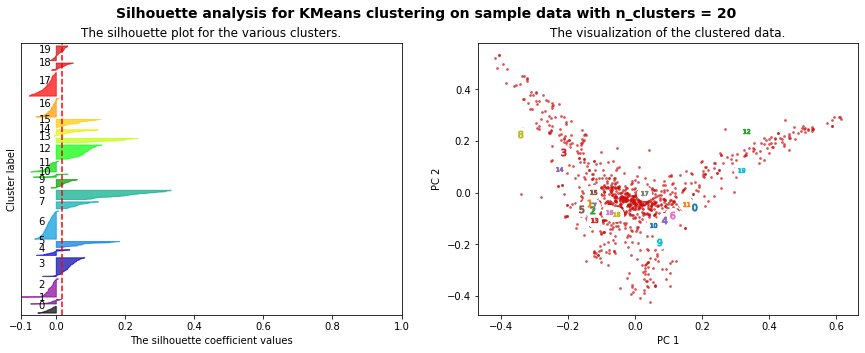

For n_clusters = 20, The average silhouette_score is : 0.019


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


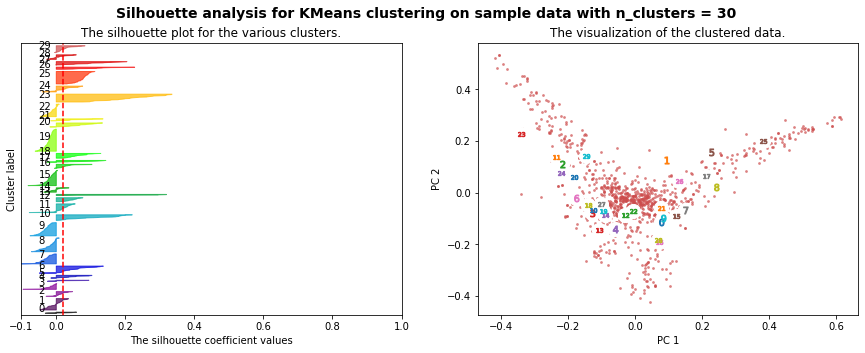

For n_clusters = 30, The average silhouette_score is : 0.021


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


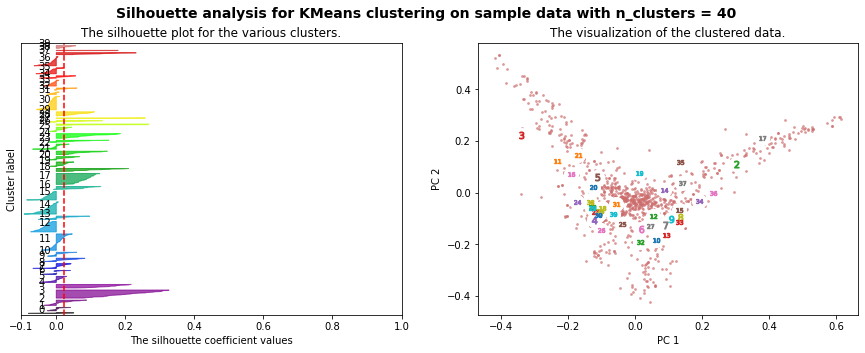

For n_clusters = 40, The average silhouette_score is : 0.025


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


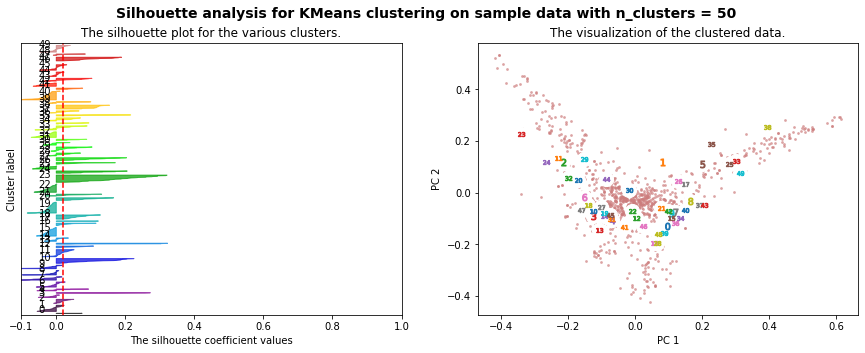

For n_clusters = 50, The average silhouette_score is : 0.022


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


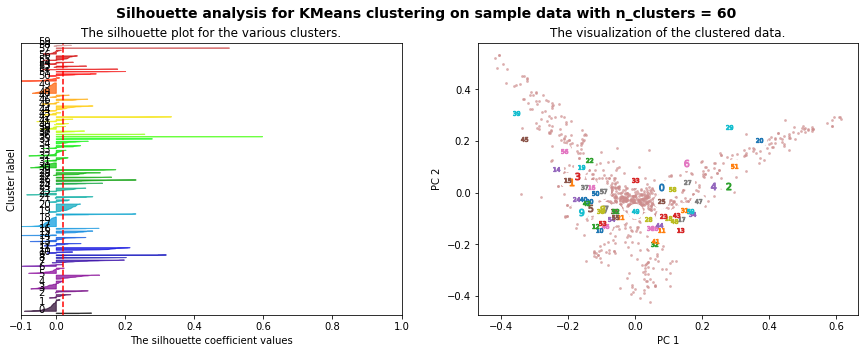

For n_clusters = 60, The average silhouette_score is : 0.020


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


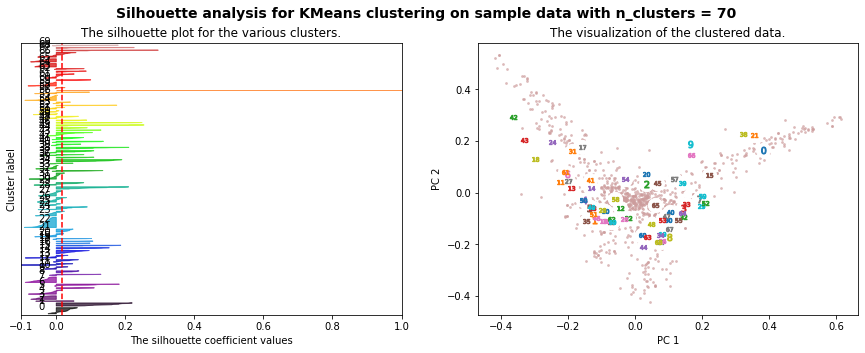

For n_clusters = 70, The average silhouette_score is : 0.018


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


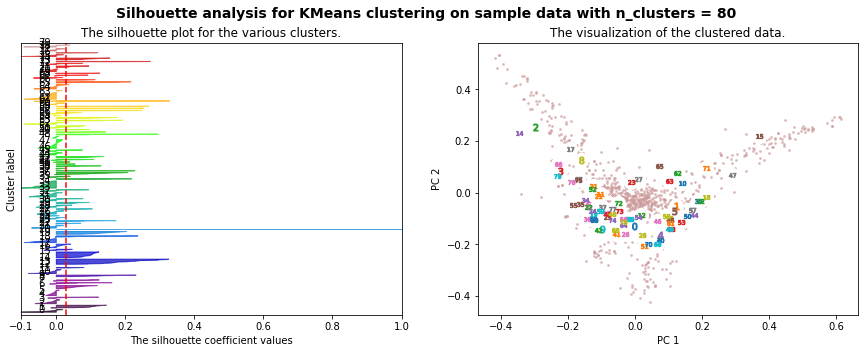

For n_clusters = 80, The average silhouette_score is : 0.030


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


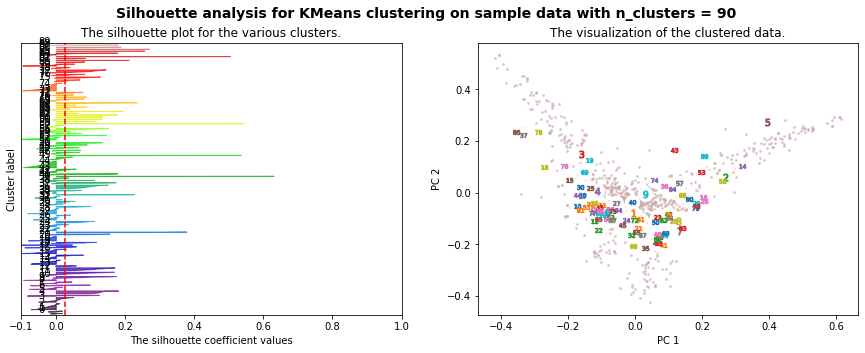

For n_clusters = 90, The average silhouette_score is : 0.027


In [55]:
for cluster_num in range(10, 100, 10):
    X = speechTFVects.toarray()
    plotSilhouette(cluster_num, X)

When setting the number of clustering from 10 to 90 with step equals 10, it shows that categorizing the presidential speeches corpora with **80** clusters has the best score of 0.30. This reveals that there are distinctive differences in presidential speeches, which may not only be influenced by the topic of the talking but also be impacted by the speech styles of each U.S. president.

# Hierarchical Clustering with Wald's Method

Next we approach a hierchical clustering method, which proposes nested clusters at any resolution (at the finest resolution, every document is its own cluster).

Here we must begin by calculating how similar the documents are to one another.

As a first pass, we take our matrix of word counts per document
`newsgroupsTFVects` and create a word occurrence matrix measuring how similar
the documents are to each other based on their number of shared words. (Note one could perform the converse operation, a document occurrence matrix measuring how similar  words are to each other based on their number of collocated documents).

In [56]:
newsgroupsTFVects

<2350x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 55644 stored elements in Compressed Sparse Row format>

In [57]:
newsgroupsTFVects[:100].todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.02540991, ..., 0.00684522, 0.00362269,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [58]:
newsgroupsCoocMat = newsgroupsTFVects * newsgroupsTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
newsgroupsCoocMat.setdiag(0)
#Another way of relating the texts is with their cosine similarity
newsgroupsCosinMat1 = 1 - sklearn.metrics.pairwise.cosine_similarity(newsgroupsTFVects)
#But generally word occurrence is more accurate

Now we can compute a tree of nested clusters. Here we will only look at the first 50 texts of each class because drawing the dendrograms can be computationally intensive (and visually complex).

In [59]:
set(newsgroupsDF['category'])

{'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos'}

In [60]:
selectIndices = []
indexToCat = []
for c in set(newsgroupsDF['category']):
    selectIndices += list(newsgroupsDF[newsgroupsDF['category'] == c].index)[:50]
    indexToCat += [c] * 50
    #.groupby('category').sum()

In [61]:
subCoocMat = newsgroupsCoocMat[selectIndices,:][:,selectIndices]

In [62]:
linkage_matrix = scipy.cluster.hierarchy.ward(subCoocMat.toarray())
linkage_matrix[:10]

array([[ 76.        , 193.        ,   0.        ,   2.        ],
       [195.        , 200.        ,   0.        ,   3.        ],
       [198.        , 201.        ,   0.        ,   4.        ],
       [  5.        , 202.        ,   0.37033177,   5.        ],
       [ 54.        , 169.        ,   0.40914841,   2.        ],
       [ 10.        ,  44.        ,   0.44134524,   2.        ],
       [ 49.        , 162.        ,   0.45096656,   2.        ],
       [151.        , 204.        ,   0.4553535 ,   3.        ],
       [ 67.        , 206.        ,   0.4650683 ,   3.        ],
       [  2.        ,  46.        ,   0.46944808,   2.        ]])

Now we can visualize the tree

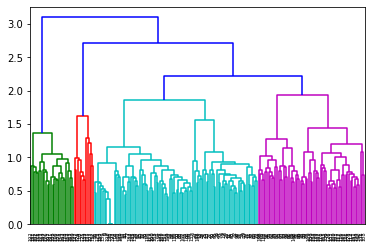

In [63]:
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, get_leaves=True)

This plot may seem somewhat unwieldy. To make it easier to read, we can cut the tree after a number of branchings.

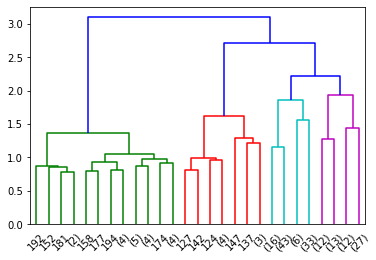

In [64]:
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)

By default, the tree is colored to show the clusters based on their ['distance'](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram) from one another, but there are other ways of forming hierarchical clusters.

Another approach involves cutting the tree into `n` branches. We can do this with [`fcluster()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster). Lets break the tree into 4 clusters. When we do this with all of the data in the dataframe, as below, we can add those clusters back for detailed evaluation.

In [65]:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 4, 'maxclust')
hierarchicalClusters

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 4,
       4, 3, 3, 4, 4, 4, 3, 4, 4, 4, 3, 2, 4, 4, 3, 4, 3, 4, 4, 4, 4, 4,
       4, 4, 3, 4, 3, 4, 4, 4, 4, 3, 3, 4, 4, 4, 1, 4, 4, 4, 4, 2, 4, 4,
       3, 4, 4, 4, 4, 4, 3, 4, 2, 4, 4, 4, 3, 2, 2, 2, 4, 2, 4, 4, 3, 4,
       2, 4, 4, 4, 4, 2, 3, 2, 4, 4, 2, 4, 4, 4, 4, 2, 4, 3, 4, 3, 1, 1,
       1, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 1, 1, 1, 3, 3, 1, 1, 1, 3, 1, 1,
       1, 1, 1, 3, 1, 1, 1, 3, 1, 3, 3, 3, 4, 3, 3, 1, 1, 3, 1, 3, 3, 1,
       3, 4], dtype=int32)

We can use this *get clusters* like we did with k-means. What if we do the full data set?

In [66]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(newsgroupsCoocMat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 4, 'maxclust')
print("For our complete clusters:")
print("\nHomogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("\nCompleteness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("\nV-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("\nAdjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], hierarchicalClusters_full)))

For our complete clusters:

Homogeneity: 0.313

Completeness: 0.370

V-measure: 0.339

Adjusted Rand Score: 0.228


Not quite as good as k-means. Perhaps we've got too many words for Ward or maybe we shouldn't be using TF-IDF as that compresses the space. Still, the hierarchical model places constraints on the clustering not present with k-means, which come at a cost. Finally, we can bring those cluster assignments back to the data frame for deeper investigation.

In [67]:
newsgroupsDF['wald_predictions'] = hierarchicalClusters_full
newsgroupsDF

,text,category,source_file,kmeans_predictions,wald_predictions
0,"\tIn certain Apple 13"" RGB monitors there has ...",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0,4
1,Does anyone know how to reach Micron? I am in...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0,4
2,Hi there!\n\nCould some kind soul tell me what...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0,4
3,"""auto\nfrom",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0,4
4,\n\n Don't believe the hype. There is no su...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0,4
...,...,...,...,...,...
2345,I was wondering if anyone out in net-land have...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,0,4
2346,\n\n\n\n\nI sold my '86 Sprint last April with...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,2,2
2347,"Actually I wasn't too surprised, since I bough...",rec.autos,../data/scikit_learn_data/20news_home/20news-b...,2,2
2348,\n\nI couldnt agree more. That is how it SHOU...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,0,4


# Now let's do it with Senate press release data

We can also do hierarchical clustering with the Senate data. Let's start by creating the linkage matrix:

In [68]:
exampleCoocMat = exampleTFVects * exampleTFVects.T
exampleCoocMat.setdiag(0)
examplelinkage_matrix = scipy.cluster.hierarchy.ward(exampleCoocMat[:100, :100].toarray())

And visualize the tree:

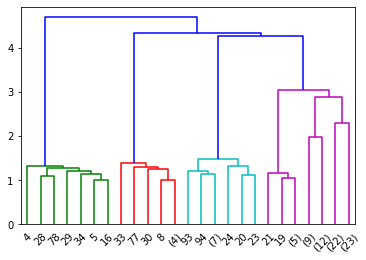

In [69]:
ax = scipy.cluster.hierarchy.dendrogram(examplelinkage_matrix, p=5, truncate_mode='level')

Now let's do it with the entire data frame.

In [70]:
example_linkage_matrix_full = scipy.cluster.hierarchy.ward(exampleCoocMat.toarray())
example_hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(example_linkage_matrix_full, 4, 'maxclust')

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that hierarchically cluster your documents using two approaches, and visualize them with a tree. Interrogate the recursive cluster contents in terms of both documents and closenesses. What does this nested cluster structure reveal about the organization of documents in your sampled corpora? Moreover, if they do worse than kmeans (as above), why do you think this is the case (hint: using metrics if you have ground truth or silhouette if you do not)? 

<span style="color:red">***Stretch***: Attempt using different distances into your clustering algorithms. (How) do they change the arrangement of clusters?

In [71]:
speechesCoocMat = speechTFVects * speechTFVects.T
speechesCoocMat.setdiag(0)
speechesLinkageMat = scipy.cluster.hierarchy.ward(speechesCoocMat.toarray())

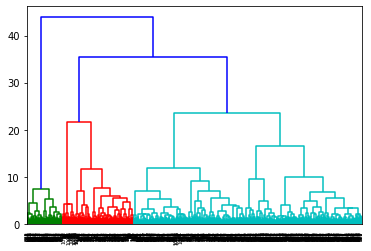

In [72]:
ax = scipy.cluster.hierarchy.dendrogram(speechesLinkageMat)

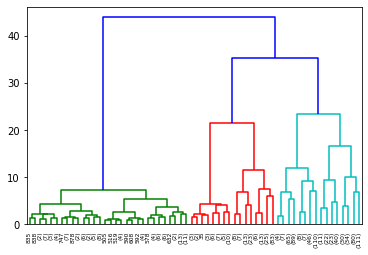

In [73]:
ax = scipy.cluster.hierarchy.dendrogram(speechesLinkageMat, p=5, truncate_mode="level", get_leaves=True)

In [74]:
# Another approach involves cutting the tree in to `n` branches
# Use `fcluster()` to break the tree into 10 branches
speechHierarchicalClusters = scipy.cluster.hierarchy.fcluster(speechesLinkageMat, 10, "maxclust")

print("For our complete clusters: \n")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(speech["script"], speechHierarchicalClusters)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(speech["script"], speechHierarchicalClusters)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(speech["script"], speechHierarchicalClusters)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(speech["script"], speechHierarchicalClusters)))

For our complete clusters: 

Homogeneity: 0.310
Completeness: 1.000
V-measure: 0.474
Adjusted Rand Score: 0.000


Recall that the Homogeneity, Completeness, V-measure and Afjusted Rand Score for the k-means clustering are 0.208, 1.000, 0.345 and 0.000 respectively, so the hierarchy clustering with Wald's method performs better.

In [76]:
# Save the clustering results into a DataFrame
speech["wald_pred"] = speechHierarchicalClusters
speech.sample(10, random_state=25)

,link,title,date,name,source,script,wald_pred
256,https://millercenter.org/the-presidency/presid...,"October 6, 1976: Debate with President Gerald ...","October 06, 1976",Jimmy Carter,National Archives,\nTranscript\nGood evening. I am Pauline Frede...,3
49,https://millercenter.org/the-presidency/presid...,"October 21, 2011: Remarks on the End of the Wa...","October 21, 2011",Barack Obama,NaN,"\nTranscript\nGood afternoon, everybody. As a...",5
224,https://millercenter.org/the-presidency/presid...,"December 23, 1981: Address to the Nation on Ch...","December 23, 1981",Ronald Reagan,Miller Center,\nTranscript\nGood evening.\nAt Christmas time...,5
838,https://millercenter.org/the-presidency/presid...,"December 8, 1846: Second Annual Message to Con...","December 08, 1846",James K. Polk,(not specified),TranscriptFellow-Citizens of the Senate and of...,1
344,https://millercenter.org/the-presidency/presid...,"January 4, 1965: State of the Union\n","January 04, 1965",Lyndon B. Johnson,National Archives,"\nTranscript\nMr. Speaker, Mr. President, memb...",4
766,https://millercenter.org/the-presidency/presid...,"May 29, 1865: Proclamation Pardoning Persons w...","May 29, 1865",Andrew Johnson,(not specified),TranscriptWhereas the President of the United ...,9
631,https://millercenter.org/the-presidency/presid...,"December 17, 1895: Message Regarding Venezuela...","December 17, 1895",Grover Cleveland,(not specified),TranscriptTo the Congress:\nIn my annual messa...,10
1004,https://millercenter.org/the-presidency/presid...,"March 11, 2020: Statement on the Coronavirus\n","March 11, 2020",Donald Trump,The White House,"\nTranscript\nMy fellow Americans: Tonight, I ...",5
113,https://millercenter.org/the-presidency/presid...,"May 11, 2001: Proposal for Global Fund to Figh...","May 11, 2001",George W. Bush,George W. Bush Presidential Library and Museum,\nTranscript\nIt is my honor to welcome our fr...,5
806,https://millercenter.org/the-presidency/presid...,"August 1, 1854: Message Regarding US-Spanish R...","August 01, 1854",Franklin Pierce,(not specified),TranscriptTo the Senate of the United States:\...,10


# Gensim

To do topic modeling we will also be using data from the [grimmer press releases corpus](https://github.com/lintool/GrimmerSenatePressReleases). To use the texts with gensim we need to create a `corpua` object, this takes a few steps. First we create a `Dictionary` that maps tokens to ids.

In [77]:
#Apply our functions
senReleasesTraining['tokenized_text'] = senReleasesTraining['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
senReleasesTraining['normalized_tokens'] = senReleasesTraining['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

In [78]:
senReleasesTraining[::100]

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator,kmeans_predictions,tokenized_text,normalized_tokens
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, conta..."
100,101,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,02Feb2006Kennedy8.txt,raw/Kennedy/02Feb2006Kennedy8.txt,FOR IMMEDIATE RELEASE Washington DC...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immediate, release, washington, dc, today, se..."
200,201,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,04May2006Kennedy7.txt,raw/Kennedy/04May2006Kennedy7.txt,FOR IMMEDIATE RELEASE FOR IMMEDI...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, washi..."
300,301,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,06Jun2006Kennedy5.txt,raw/Kennedy/06Jun2006Kennedy5.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, surpr..."
400,401,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,08Dec2006Kennedy4.txt,raw/Kennedy/08Dec2006Kennedy4.txt,FOR IMMEDIATE RELEASE Washington D ...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, Washington, D, C, To...","[immediate, release, washington, have, c, toda..."
500,501,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,09Nov2005Kennedy10.txt,raw/Kennedy/09Nov2005Kennedy10.txt,FOR IMMEDIATE RELEASE Washington ...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immediate, release, washington, dc, today, se..."
600,601,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,11Nov2005Kennedy5.txt,raw/Kennedy/11Nov2005Kennedy5.txt,FOR IMMEDIATE RELEASE On this Vet...,Kennedy,0,"[FOR, IMMEDIATE, RELEASE, On, this, Veteran, s...","[immediate, release, veteran, s, day, america,..."
700,701,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,13Jun2006Kennedy0.txt,raw/Kennedy/13Jun2006Kennedy0.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, mr, c..."
800,801,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,15Dec2005Kennedy4.txt,raw/Kennedy/15Dec2005Kennedy4.txt,FOR IMMEDIATE RELEASE Washington ...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immediate, release, washington, dc, today, se..."
900,901,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,16May2007Kennedy10.txt,raw/Kennedy/16May2007Kennedy10.txt,FOR IMMEDIATE RELEASE WASHINGTON D ...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, WASHINGTON, D, C, Se...","[immediate, release, washington, have, c, sena..."


In [79]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

senReleasesTraining['reduced_tokens'] = senReleasesTraining['normalized_tokens'].apply(lambda x: dropMissing(x, senTFVectorizer.vocabulary_.keys()))

In [80]:
dictionary = gensim.corpora.Dictionary(senReleasesTraining['reduced_tokens'])

Then for each of the texts we create a list of tuples containing each token and its count. We will only use the first half of our dataset for now and will save the remainder for testing.

In [81]:
corpus = [dictionary.doc2bow(text) for text in senReleasesTraining['reduced_tokens']]

Then we serialize the corpus as a file and load it. This is an important step when the corpus is large.

In [82]:
gensim.corpora.MmCorpus.serialize('senate.mm', corpus)
senmm = gensim.corpora.MmCorpus('senate.mm')

Now we have a correctly formatted corpus that we can use for topic modeling and induction.

In [83]:
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

We can inspect the degree to which distinct texts load on different topics. Here is one of the texts from the training set:

In [84]:
sen1Bow = dictionary.doc2bow(senReleasesTraining['reduced_tokens'][0])
sen1lda = senlda[sen1Bow]
print("The topics of the text: {}".format(senReleasesTraining['name'][0]))
print("are: {}".format(sen1lda))

The topics of the text: 01Apr2005Kennedy14.txt
are: [(9, 0.9735204)]


We can now see which topics our model predicts press releases load on and make this into a `dataFrame` for later analysis.

In [85]:
ldaDF = pandas.DataFrame({
        'name' : senReleasesTraining['name'],
        'topics' : [senlda[dictionary.doc2bow(l)] for l in senReleasesTraining['reduced_tokens']]
    })

This is a bit unwieldy so lets make each topic its own column:

In [86]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF[1::100]

,name,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
1,01Aug2005Kennedy12.txt,"[(2, 0.9716841)]",0.000000,0.000000,0.971684,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
101,02Feb2007Kennedy10.txt,"[(4, 0.36711657), (6, 0.5910573), (9, 0.037904...",0.000000,0.000000,0.000000,0.000000,0.367117,0.000000,0.591057,0.000000,0.000000,0.037905
201,04May2006Kennedy8.txt,"[(3, 0.028086377), (7, 0.87896144), (8, 0.0786...",0.000000,0.000000,0.000000,0.028086,0.000000,0.000000,0.000000,0.878961,0.078686,0.012678
301,06Jun2007Kennedy1.txt,"[(1, 0.021484042), (6, 0.13519454), (7, 0.5700...",0.000000,0.021484,0.000000,0.000000,0.000000,0.000000,0.135195,0.570069,0.271887,0.000000
401,08Feb2005Kennedy0.txt,"[(3, 0.12499342), (7, 0.86908805)]",0.000000,0.000000,0.000000,0.124993,0.000000,0.000000,0.000000,0.869088,0.000000,0.000000
501,09Nov2005Kennedy11.txt,"[(2, 0.27545807), (5, 0.68564636)]",0.000000,0.000000,0.275458,0.000000,0.000000,0.685646,0.000000,0.000000,0.000000,0.000000
601,11Nov2005Kennedy6.txt,"[(1, 0.97250056)]",0.000000,0.972501,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
701,13Jun2006Kennedy1.txt,"[(6, 0.20049842), (7, 0.6908622), (9, 0.106329...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200498,0.690862,0.000000,0.106329
801,15Dec2005Kennedy5.txt,"[(0, 0.12558664), (3, 0.07820574), (5, 0.15147...",0.125587,0.000000,0.000000,0.078206,0.000000,0.151479,0.000000,0.643552,0.000000,0.000000
901,16May2007Kennedy5.txt,"[(3, 0.17809638), (8, 0.7809801)]",0.000000,0.000000,0.000000,0.178096,0.000000,0.000000,0.000000,0.000000,0.780980,0.000000


Now let's visualize this for several (e.g., 10) documents in the corpus. First we'll subset the data:

In [87]:
ldaDFV = ldaDF[:10][['topic_%d' % x for x in range(10)]]
ldaDFVisN = ldaDF[:10][['name']]
ldaDFVis = ldaDFV.values
ldaDFVisNames = ldaDFVisN.values
ldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.973520
1,0.000000,0.0,0.971684,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
2,0.000000,0.0,0.000000,0.993007,0.0,0.000000,0.000000,0.0,0.000000,0.000000
3,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.993996
4,0.030760,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.967204,0.000000
5,0.920889,0.0,0.000000,0.071419,0.0,0.000000,0.000000,0.0,0.000000,0.000000
6,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.865701,0.0,0.125077,0.000000
7,0.000000,0.0,0.000000,0.000000,0.0,0.967688,0.000000,0.0,0.000000,0.000000
8,0.000000,0.0,0.000000,0.995048,0.0,0.000000,0.000000,0.0,0.000000,0.000000
9,0.000000,0.0,0.000000,0.830323,0.0,0.000000,0.000000,0.0,0.140705,0.000000


First we can visualize as a stacked bar chart:

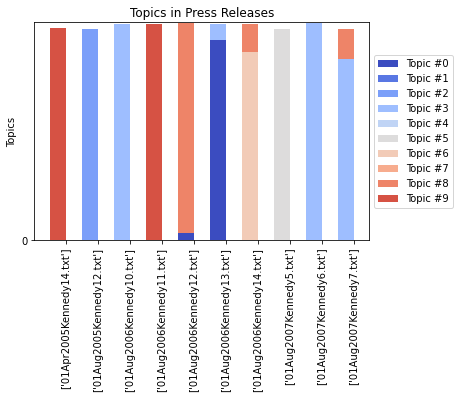

In [88]:
N = 10
ind = np.arange(N)
K = senlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

We can also visualize as a heat map:

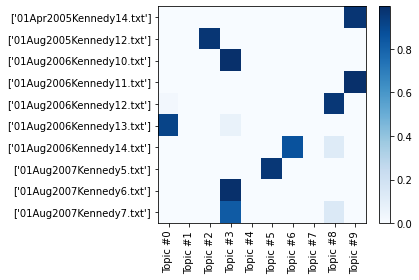

In [89]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

We can also look at the top words from each topic to get a sense of the semantic (or syntactic) domain they represent. To look at the terms with the highest LDA weight in topic `1` we can do the following:

In [90]:
senlda.show_topic(1)

[('fund', 0.007507593),
 ('worker', 0.0066558835),
 ('loan', 0.0054029273),
 ('victim', 0.004407795),
 ('asbestos', 0.00420876),
 ('judge', 0.0042020413),
 ('bankruptcy', 0.0041302773),
 ('company', 0.0041189594),
 ('lender', 0.0032601163),
 ('compensation', 0.0031282478)]

And if we want to make a dataFrame:

In [91]:
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,wage,fund,fund,loan,troop,fund,fund,fund,worker,fund
1,worker,worker,worker,lender,fund,head,judge,worker,pension,troop
2,minimum,loan,asbestos,wage,worker,worker,worker,immigration,company,fda
3,fund,victim,train,rate,loan,troop,violence,immigrant,employee,unite
4,head,asbestos,victim,worker,woman,wage,unite,head,retirement,minimum
5,woman,judge,woman,aid,unite,teacher,crime,insurance,wage,loan
6,pension,bankruptcy,insurance,minimum,mental,medicare,follow,patient,rule,wage
7,hour,company,unite,fund,rule,company,resource,standard,unite,food
8,teacher,lender,standard,borrower,judge,science,troop,agency,employer,association
9,agency,compensation,trust,list,rate,unite,victim,coverage,fund,fail


We can see that several of the topics have the same top words, but there are definitely differences. We can try and make the topics more distinct by changing the $\alpha$ and $\eta$ parameters of the model. **$\alpha$ controls the sparsity of document-topic loadings, and $\eta$ controls the sparsity of topic-word loadings.**

We can make a visualization of the distribution of words over any single topic.

<Figure size 432x288 with 0 Axes>

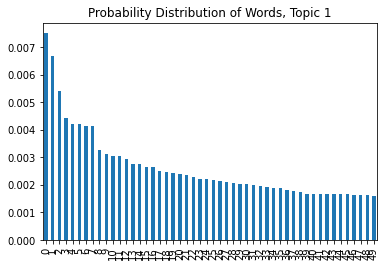

In [92]:
topic1_df = pandas.DataFrame(senlda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

See how different $\eta$ values can change the shape of the distribution.

In [93]:
senlda1 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.00001)
senlda2 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.9)

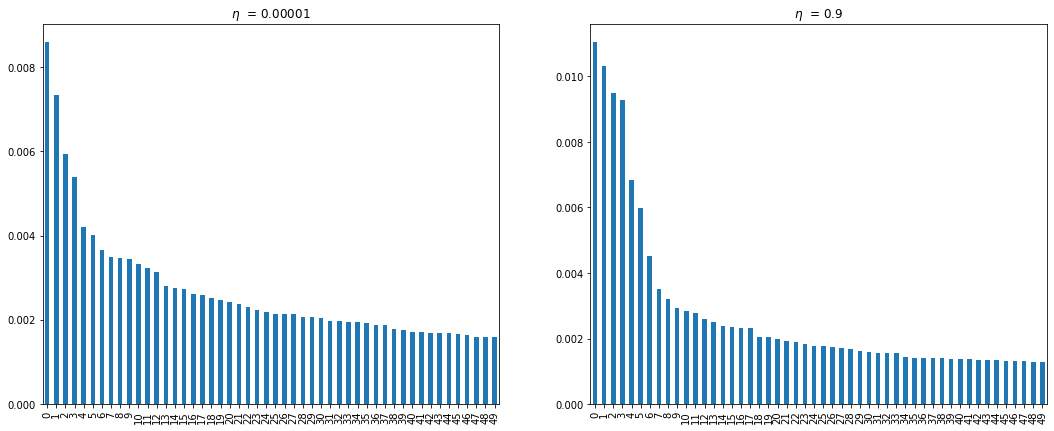

In [94]:
topic11_df = pandas.DataFrame(senlda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(senlda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that topic model documents related to your anticipated final project. Interrogate and visually plot (e.g., as a bar graph?) the topic-word loadings and the document-topic loadings. What does this topic structure reveal about the distribution of contents across your documents? Systematically vary the $\alpha$, $\eta$, and topic number of the model for your text and describe in detail whether and how these changes led to distinctive outcomes, visible to you as analyst.  

<span style="color:red">**Stretch**: Cluster your documents, but instead of using words alone, use their topic loadings as an additional set of features. Do these topic loadings increase the apparent semantic coherence of your clusters?</span> 

In [96]:
# Apply tokenization and normalization
speech["tokenized"] = speech["script"].apply(lambda x: lucem_illud_2020.word_tokenize(x))
speech["normalized"] = speech["tokenized"].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

In [97]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

speech["reduced"] = speech["normalized"].apply(lambda x: dropMissing(x, TFVectorizer.vocabulary_.keys()))

In [98]:
dictionary = gensim.corpora.Dictionary(speech["reduced"])

In [99]:
# Create a list of tuples that contains each token and its count
corpus = [dictionary.doc2bow(text) for text in speech["reduced"]]

In [100]:
# Serialize the corpus as a file and load it
gensim.corpora.MmCorpus.serialize("speeches.mm", corpus)
speeches_mm = gensim.corpora.MmCorpus("speeches.mm")

In [101]:
# Use the formatted corpus for topic modeling and induction
speeches_lda = gensim.models.ldamodel.LdaModel(corpus=speeches_mm, id2word=dictionary, num_topics=10, alpha="auto", eta="auto")

In [104]:
# Inspect the degree to which distinct texts load on different topics
speech_lBow = dictionary.doc2bow(speech["reduced"][0])
speech_lda = speeches_lda[speech_lBow]

print("The topic of the text {} are {}.".format(speech["title"].loc[25].strip(), speech_lda), sep=" ")


The topic of the text February 28, 2017: Address to Joint Session of Congress are [(0, 0.43466303), (2, 0.0822037), (3, 0.029469362), (7, 0.38629752), (9, 0.058192033)].


In [106]:
# Inspect which topics the model predicts and load into DataFrame
lda_df = pd.DataFrame({
    "name": speech["title"],
    "topics": [speeches_lda[dictionary.doc2bow(l)] for l in speech["reduced"]]
})
lda_df.sample(10, random_state=25)

,name,topics
256,"October 6, 1976: Debate with President Gerald ...","[(2, 0.0333936), (3, 0.08020968), (4, 0.022765..."
49,"October 21, 2011: Remarks on the End of the Wa...","[(0, 0.13337699), (3, 0.4950042), (4, 0.079079..."
224,"December 23, 1981: Address to the Nation on Ch...","[(2, 0.73578614), (3, 0.031827983), (5, 0.1429..."
838,"December 8, 1846: Second Annual Message to Con...","[(1, 0.0233607), (4, 0.43576798), (5, 0.040241..."
344,"January 4, 1965: State of the Union\n","[(0, 0.24118245), (2, 0.4271815), (3, 0.061399..."
766,"May 29, 1865: Proclamation Pardoning Persons w...","[(8, 0.99520963)]"
631,"December 17, 1895: Message Regarding Venezuela...","[(2, 0.045612253), (4, 0.59118843), (5, 0.0191..."
1004,"March 11, 2020: Statement on the Coronavirus\n","[(0, 0.643473), (3, 0.20949687), (7, 0.0852489..."
113,"May 11, 2001: Proposal for Global Fund to Figh...","[(0, 0.065102786), (2, 0.9302207)]"
806,"August 1, 1854: Message Regarding US-Spanish R...","[(4, 0.4679712), (5, 0.075975746), (6, 0.13920..."


In [107]:
# Show the table that makes each topic its own column

# Dict to temporally hold the probabilities
topicsProbDict = {i: [0] * len(lda_df) for i in range(speeches_lda.num_topics)}

# Load them into the dictionary
for index, topicTuples in enumerate(lda_df["topics"]):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

# Update the DataFrame
for topicNum in range(speeches_lda.num_topics):
    lda_df["topic{}".format(topicNum)] = topicsProbDict[topicNum]
    
lda_df[1::100]

,name,topics,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
1,"March 11, 2020: Statement on the Coronavirus\n","[(0, 0.68889046), (3, 0.14530559), (7, 0.09118...",0.688890,0.000000,0.000000,0.145306,0.000000,0.000000,0.000000,0.091189,0.000000,0.070619
101,"March 17, 2003: Address to the Nation on Iraq\n","[(3, 0.08286532), (4, 0.5412534), (5, 0.030241...",0.000000,0.000000,0.000000,0.082865,0.541253,0.030242,0.000000,0.137341,0.202774,0.000000
201,"October 7, 1984: Debate with Walter Mondale (D...","[(0, 0.02164232), (2, 0.02288301), (3, 0.01874...",0.021642,0.000000,0.022883,0.018741,0.000000,0.041832,0.786731,0.102954,0.000000,0.000000
301,"January 17, 1968: State of the Union Address\n","[(0, 0.50370324), (1, 0.0126154525), (2, 0.077...",0.503703,0.012615,0.077025,0.011659,0.000000,0.039727,0.018506,0.192663,0.021576,0.118012
401,"January 30, 1961: State of the Union\n","[(0, 0.14975117), (1, 0.05448452), (2, 0.29295...",0.149751,0.054485,0.292955,0.072073,0.016333,0.041713,0.040880,0.166561,0.033256,0.131992
501,"July 7, 1930: Message Regarding London Naval T...","[(0, 0.014812684), (4, 0.011517065), (7, 0.342...",0.014813,0.000000,0.000000,0.000000,0.011517,0.000000,0.000000,0.342530,0.482790,0.138936
601,"December 6, 1904: Fourth Annual Message\n","[(0, 0.090006135), (1, 0.055295143), (2, 0.170...",0.090006,0.055295,0.170625,0.014415,0.252713,0.146634,0.030370,0.028265,0.122442,0.089235
701,"December 2, 1878: Second Annual Message\n","[(0, 0.02878726), (1, 0.14247239), (2, 0.01067...",0.028787,0.142472,0.010675,0.000000,0.527647,0.073632,0.030917,0.000000,0.142250,0.034779
801,"December 31, 1855: Third Annual Message\n","[(1, 0.050778463), (4, 0.568529), (5, 0.026149...",0.000000,0.050778,0.000000,0.000000,0.568529,0.026149,0.047393,0.042597,0.227444,0.020268
901,"May 27, 1830: Veto Message Regarding Funding o...","[(1, 0.4881097), (4, 0.21687296), (5, 0.101622...",0.000000,0.488110,0.000000,0.000000,0.216873,0.101623,0.061452,0.043665,0.016871,0.056589


In [108]:
# Visualize for 10 documents in the corpus
ldaDFV = lda_df[:10][["topic%d" % x for x in range(10)]]
ldaDFVisN = lda_df[:10][["name"]]
ldaDFVis = ldaDFV.values
ldaDFVisNames = ldaDFVisN.values
ldaDFV

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
0,0.417750,0.0,0.074913,0.036321,0.000000,0.000000,0.000000,0.411730,0.000000,0.049808
1,0.688890,0.0,0.000000,0.145306,0.000000,0.000000,0.000000,0.091189,0.000000,0.070619
2,0.702736,0.0,0.000000,0.000000,0.012706,0.225677,0.000000,0.031222,0.000000,0.014413
3,0.902918,0.0,0.000000,0.000000,0.000000,0.078125,0.000000,0.015236,0.000000,0.000000
4,0.489344,0.0,0.000000,0.000000,0.000000,0.507879,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.994148,0.000000,0.000000
6,0.000000,0.0,0.000000,0.000000,0.832071,0.000000,0.000000,0.160247,0.000000,0.000000
7,0.000000,0.0,0.000000,0.000000,0.057823,0.000000,0.000000,0.933282,0.000000,0.000000
8,0.163180,0.0,0.037359,0.000000,0.070807,0.033181,0.089473,0.561685,0.000000,0.040846
9,0.071359,0.0,0.026205,0.435631,0.018037,0.012840,0.011028,0.332475,0.070066,0.021292


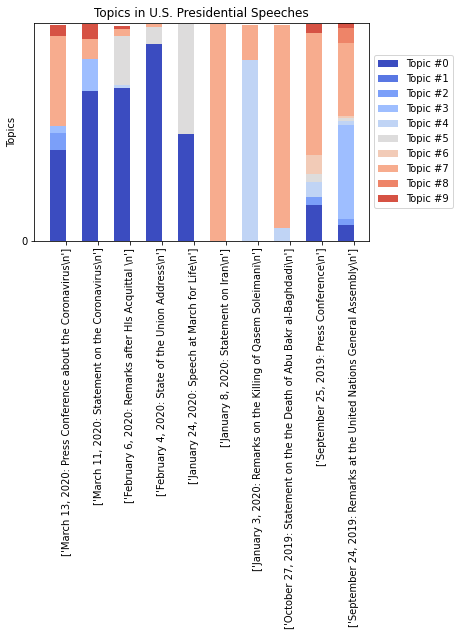

In [109]:
# Visualization as a stacked bar chart
N = 10
ind = np.arange(N)  # The x-axis locations for the novels
K = speeches_lda.num_topics  # N documents, K topics
width = 0.5  # The width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k / K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)

plt.ylim((0, 1)) # Proporations sum to one, so the height of the stacked bars is one
plt.ylabel("Topics")

plt.title("Topics in U.S. Presidential Speeches")
plt.xticks(ind + width / 2, ldaDFVisNames, rotation="vertical")
plt.yticks(np.arange(0, 1, 10))
topic_labels = ["Topic #{}".format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc="center left", frameon=True, bbox_to_anchor=(1, 0.5))

plt.show()

**The predicted topic structure to some extent is consistent with the actual topics addressed in the presidential speeches.** For example, the first two bars to the left of the figure exhibit similar probability distributions since they are both concerned with the coronavirus. Moreover, The latest two talkings distinctively distinguished from the one related with the killing of Qasem Soleimani. 

**However, the prediction is not very accurate.** It is the model identifies that the acquital speech on February 6, 2020, and the speech on life on January 24, 2020 to be high-proporationately similar, which seems conter-intuitive.

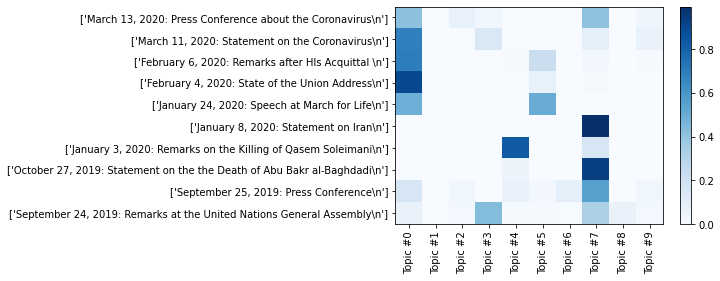

In [110]:
# Visualize as a heatmap
plt.pcolor(ldaDFVis, norm=None, cmap="Blues")
plt.yticks(np.arange(ldaDFVis.shape[0]) + 0.5, ldaDFVisNames)
plt.xticks(np.arange(ldaDFVis.shape[0]) + 0.5, topic_labels)

# Flip the y-axis so the texts are in the order we anticipate
plt.gca().invert_yaxis()

# Rotate the ticks on the x-axis
plt.xticks(rotation=90)
plt.colorbar(cmap="Blues")
plt.show()

In [111]:
# Look at the top words from each topic to get a sense of semantic or syntactic domain they represent
speeches_lda.show_topic(1)

[('unite', 0.005423795),
 ('bank', 0.0044061653),
 ('citizen', 0.0041345),
 ('think', 0.0037330592),
 ('man', 0.003582746),
 ('subject', 0.0026691526),
 ('live', 0.002616137),
 ('pass', 0.0025296689),
 ('increase', 0.0025288018),
 ('mean', 0.0024808377)]

In [112]:
# Show in DataFrame
topicsDict = {}
for topicNum in range(speeches_lda.num_topics):
    topicWords = [w for w, p in speeches_lda.show_topic(topicNum)]
    topicsDict['Topic{}'.format(topicNum)] = topicWords

speeches_wordRanksDF = pd.DataFrame(topicsDict)
speeches_wordRanksDF

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9
0,unite,unite,unite,unite,unite,think,unite,unite,unite,unite
1,applause,bank,man,think,man,unite,mr,increase,man,man
2,man,citizen,think,man,think,man,think,question,increase,think
3,increase,think,mr,mr,question,applause,question,constitution,service,increase
4,think,man,mean,increase,citizen,subject,increase,mr,citizen,citizen
5,citizen,subject,help,citizen,mr,child,man,think,provide,federal
6,provide,live,question,report,mean,increase,citizen,americans,treaty,condition
7,job,pass,citizen,provide,increase,citizen,subject,man,today,mean
8,service,increase,service,subject,service,question,mean,citizen,person,today
9,help,mean,subject,live,subject,mean,pass,treaty,question,question


The top five words for each topic largely overlaps with each other, such as "unite", "man", "mr", "think" and etc., which causes difficulty in identifying what a particular topic refers to. This problem probably stems from not thoroughly getting rid of all the stop words in presidential speeches during the pre-processing phrases and leads to the inaccuracy prediction of the topic clustering.

<Figure size 432x288 with 0 Axes>

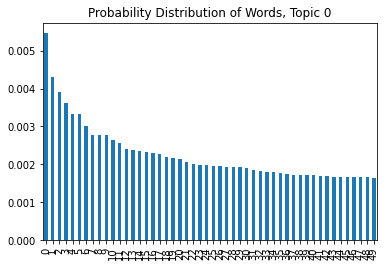

<Figure size 432x288 with 0 Axes>

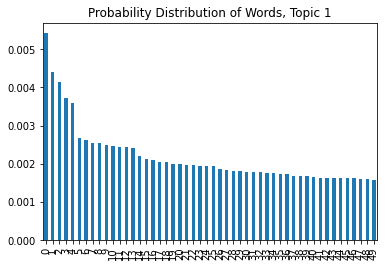

<Figure size 432x288 with 0 Axes>

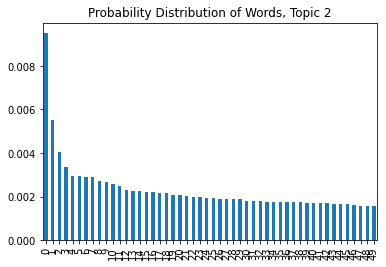

<Figure size 432x288 with 0 Axes>

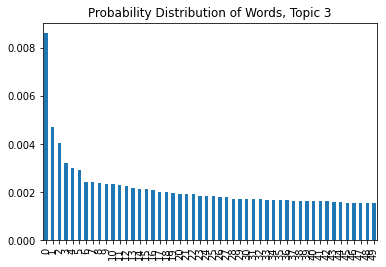

<Figure size 432x288 with 0 Axes>

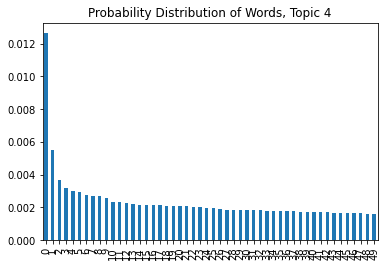

<Figure size 432x288 with 0 Axes>

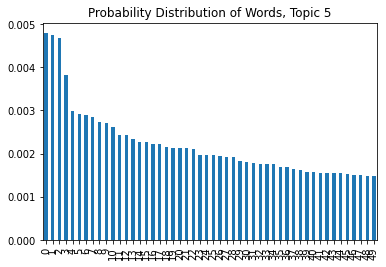

<Figure size 432x288 with 0 Axes>

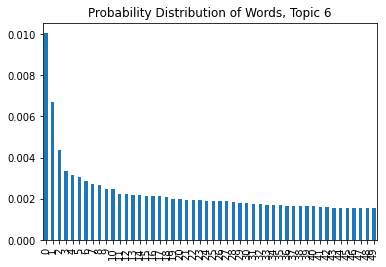

<Figure size 432x288 with 0 Axes>

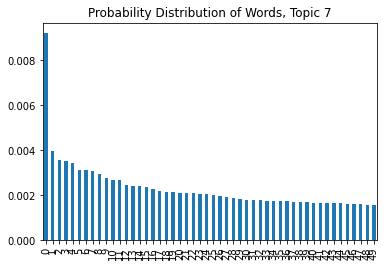

<Figure size 432x288 with 0 Axes>

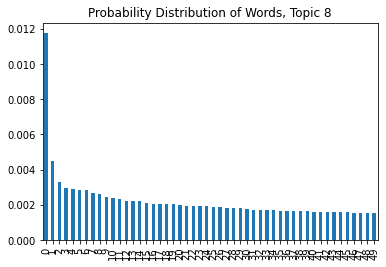

<Figure size 432x288 with 0 Axes>

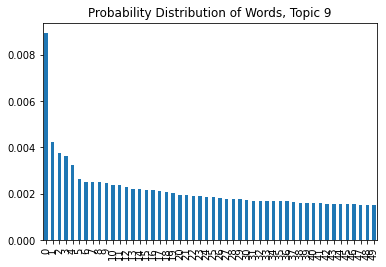

In [113]:
# Make a visualization of the distribution of the words over any single topic
for topicNum in range(speeches_lda.num_topics):
    topic1_df = pd.DataFrame(speeches_lda.show_topic(topicNum, topn=50))
    plt.figure()
    topic1_df.plot.bar(legend=False)
    plt.title("Probability Distribution of Words, Topic {}".format(topicNum))
    plt.show()

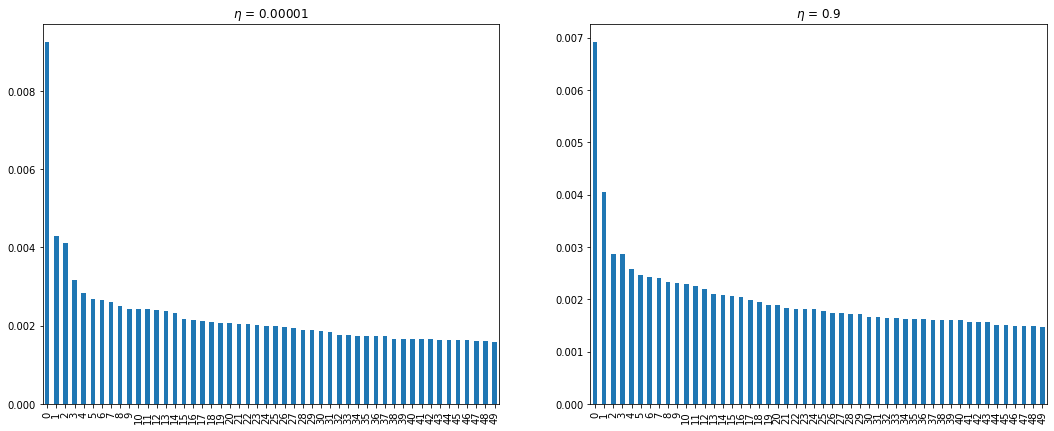

In [114]:
# Change parameters $eta$ for topic 1
speech_lda1 = gensim.models.ldamodel.LdaModel(corpus=speeches_mm, id2word=dictionary, num_topics=10, alpha="auto", eta=0.00001)
speech_lda2 = gensim.models.ldamodel.LdaModel(corpus=speeches_mm, id2word=dictionary, num_topics=10, alpha="auto", eta=0.9)

topic11_df = pd.DataFrame(speech_lda1.show_topic(1, topn=50))
topic21_df = pd.DataFrame(speech_lda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend=False, ax=ax1, title=r"$\eta$ = 0.00001")
topic21_df.plot.bar(legend=False, ax=ax2, title=r"$\eta$ = 0.9")

$\eta$ is the parameter that sets the topic distribution for the words. The higher the $\eta$, the more spread out the words will be across the specified number of topics. As shown in the pictures above, the distribution is more spread when $\eta=0.9$ while the first three terms of the distribution are very distinctive from the latter ones.

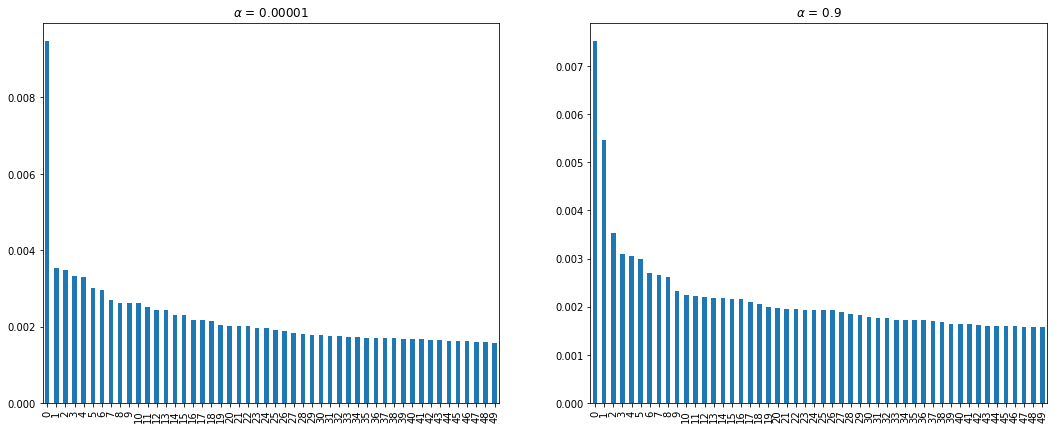

In [115]:
# Change parameters $alpha$ for topic 1
speech_lda1 = gensim.models.ldamodel.LdaModel(corpus=speeches_mm, id2word=dictionary, num_topics=10, alpha=0.00001, eta="auto")
speech_lda2 = gensim.models.ldamodel.LdaModel(corpus=speeches_mm, id2word=dictionary, num_topics=10, alpha=0.9, eta="auto")

topic11_df = pd.DataFrame(speech_lda1.show_topic(1, topn=50))
topic21_df = pd.DataFrame(speech_lda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend=False, ax=ax1, title=r"$\alpha$ = 0.00001")
topic21_df.plot.bar(legend=False, ax=ax2, title=r"$\alpha$ = 0.9")

$\alpha$ is the parameter that sets the topic distribution for the documents. The higher the $\alpha$, the more spread out the documents will be across the specified number of topics. As shown in the pictures above, the first few terms have higher probabilities in the distribution with $\alpha=0.0001$ while when $\alpha=0.9$, the distribution of topics within one document is more spread.

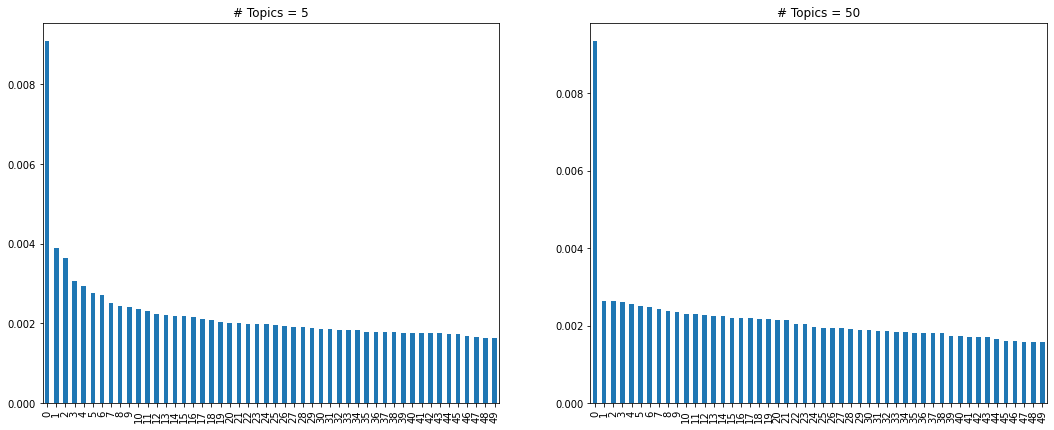

In [116]:
# Change the number of topics
speech_lda1 = gensim.models.ldamodel.LdaModel(corpus=speeches_mm, id2word=dictionary, num_topics=5, alpha="auto", eta="auto")
speech_lda2 = gensim.models.ldamodel.LdaModel(corpus=speeches_mm, id2word=dictionary, num_topics=50, alpha="auto", eta="auto")

topic11_df = pd.DataFrame(speech_lda1.show_topic(1, topn=50))
topic21_df = pd.DataFrame(speech_lda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend=False, ax=ax1, title=r"# Topics = 5")
topic21_df.plot.bar(legend=False, ax=ax2, title=r"# Topics = 50")

The probability distribution of first five terms is more concentrated if the parameter denoting the topic number is five, while the distribution becomes more sparse with the number of topics equals to 50.

## Extending Topic Models within broader research pipelines

Topic models can be the base of more complex analysis. One good example is the paper - Individuals, institutions, and innovation in the debates of the French Revolution (https://www.pnas.org/content/115/18/4607), where they use topic models to find similarities and differences between the topics of different individuals. Let us revisit this idea using the Soap opera database. Who innovates and influences the most within the Soap?

The next few lines of code follows the same process as last weeks notebook. Please visit the old notebook to read descriptions of the code if you have forgotten what it does.

In [117]:
corpora_address = "/Users/linghuiwu/uchicago/courseworks/soci40133/Content-Analysis-2020/week-5/Soup"

In [118]:
soap_texts = lucem_illud_2020.loadDavies(corpora_address, num_files=10)

text_7-jss.zip
text_6-egn.zip
text_5-rag.zip
text_2-wts.zip
text_3-pem.zip
text_4-jfy.zip
text_8-sbo.zip
text_9-jtw.zip
text_0-tez.zip
text_1-teh.zip


In [119]:
import zipfile

In [120]:
zfile = zipfile.ZipFile(corpora_address + "/soap_sources.zip")
source = []

In [121]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [122]:
soap_dict = {}

In [123]:
for soap in source[3:]:
    try:
        textID, year, show, url = soap.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    except ValueError:
        continue
    if show.strip() not in soap_dict:
        soap_dict[show.strip()] = []
    if show.strip() in soap_dict:
        try:
            soap_dict[show.strip()].append(soap_texts[textID.strip()])
        except KeyError:
            continue

In [124]:
soap_dict.keys()

dict_keys(['All My Childen', 'As the World Turns', 'Bold and Beautiful', 'Days of Our Lives', 'General Hospital', 'Guiding Light', 'One Life to Live', 'Passions', 'Port Charles', 'Young and Restless'])

In [125]:
soap_df = pd.DataFrame(columns=["Soap Name", "Tokenized Texts"])

In [126]:
i = 0

In [127]:
for soap in soap_dict:
    # since there were multiple lists
    print(soap)
    full_script = []
    for part in soap_dict[soap]:
        full_script = full_script + part
    soap_df.loc[i] = [soap, full_script]
    i += 1

All My Childen
As the World Turns
Bold and Beautiful
Days of Our Lives
General Hospital
Guiding Light
One Life to Live
Passions
Port Charles
Young and Restless


In [128]:
soap_df

,Soap Name,Tokenized Texts
0,All My Childen,"[@!Reporter, Is, there, anything, you, regret,..."
1,As the World Turns,"[@!Katie, Okay, I, know, these, words, are, lo..."
2,Bold and Beautiful,"[@!Bridget, What, did, you, say, @!Deacon, Jus..."
3,Days of Our Lives,"[@!Maggie, How, are, you, doing, @!Victor, Fin..."
4,General Hospital,"[@!Luke, I, signed, my, divorce, papers, You, ..."
5,Guiding Light,"[@!Dax, I, take, it, everything, is, well, wit..."
6,One Life to Live,"[@!Blair, Excuse, me, @!Todd, Why, Did, you, d..."
7,Passions,"[@!Julian, Let, 's, drink, up, It, 's, not, ev..."
8,Port Charles,"[@!Frank, Hey, @!Karen, Hey, You, still, on, d..."
9,Young and Restless,"[@!Katherine, Any, sign, of, your, daddy, swee..."


Checking to see which index I should use. In my example it is the last one, so I choose my index as 9. It might be different for you!

In [129]:
dool = soap_df['Tokenized Texts'][9]

In [130]:
' '.join(dool[0:1500])

"@!Katherine Any sign of your daddy sweetheart @!Nikki They 'll be here soon @!Katherine They said they 're on their way @!Noah They 're here Daddy 's home @!Nicholas Where 's my boy @!Noah Yea Why are you breathing so funny Daddy @!Nicholas Because I ran all the way here I could n't wait to see you @!Katherine It 's finally over @!Nikki Thank God @!Miguel Congratulations Victoria @!Victoria Thank you Miguel You 're looking at a real hero If it were n't for Ryan Nicholas would n't be here with us @!Katherine You look wonderful Nicholas @!Nicholas I feel wonderful @!Katherine I told you your daddy was coming home @!Noah And you 're never leaving again are you Daddy @!Nicholas That 's right never Oh come on @!Ryan Welcome home Nicholas @!Nicholas Thanks @!Rianna Do n't forget your medication @!Raul No more triple chocolate cake @!Billy Been there done that @!Raul Yeah right @!Billy Hey rough We 're here for you all right @!Raul What 's rough is spending one more minute in this place @!Ri

In [131]:
characters = {}
for token in dool:
    if token[0] == '@':
        # all characters or actions start with @, so we add that to character
        if token[2:] not in characters:
            characters[token[2:]] = 0
        if token[2:] in characters:
            characters[token[2:]] += 1

In [132]:
import networkx as nx

In [133]:
actor_network = nx.Graph()

In [134]:
for character in characters:
    if characters[character] > 2000:
        actor_network.add_node(character, lines_spoken= characters[character], words=[])

In [135]:
len(dool)

1377215

In [136]:
i = 0
all_texts = []
for token in dool:
    i += 1
    if i > len(dool):
        break
    if token[0] == "@":
        if token[2:] in actor_network.nodes():
            j = i
            for token_ in dool[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network.nodes():
                        if (token[2:], token_[2:]) not in actor_network.edges():
                            actor_network.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network.edges():
                            actor_network.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network.nodes[token[2:]]['words'].append(dool[i:j])
            all_texts.append(lucem_illud_2020.normalizeTokens(dool[i:j]))

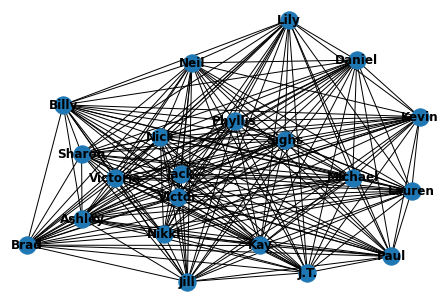

In [137]:
nx.draw(actor_network, with_labels=True, font_weight='bold')

Ok - so we have our graph now. Let us create a topic model with all the texts spoken by the characters, see what's being spoken about, and construct topic distributions for each character. What does our all_texts corpus look like?

In [138]:
all_texts[0:10]

[['soon'],
 ['thank', 'god'],
 ['thank', 'miguel', 'look', 'real', 'hero', 'ryan', 'nicholas'],
 [],
 ['hey', 'rough', 'right'],
 ['house'],
 ['right',
  'be',
  'sure',
  'mamie',
  'like',
  'help',
  'look',
  'get',
  'right',
  'glad',
  'get',
  'joint',
  'man'],
 ['yes', 'care', 'boy', 'huh'],
 ['you', 'late'],
 ['yes', 'research', 'find', 'threat', 'husband', 'pose']]

In [139]:
dictionary = gensim.corpora.Dictionary(all_texts)

In [140]:
corpus = [dictionary.doc2bow(text) for text in all_texts]

In [141]:
gensim.corpora.MmCorpus.serialize('dool.mm', corpus)
doolcorpus = gensim.corpora.MmCorpus('dool.mm')

In [142]:
doollda = gensim.models.ldamodel.LdaModel(corpus=doolcorpus, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [143]:
doollda.show_topics()

[(0,
  '0.179*"oh" + 0.074*"good" + 0.067*"come" + 0.034*"tell" + 0.030*"god" + 0.024*"night" + 0.021*"see" + 0.017*"remember" + 0.017*"ask" + 0.015*"day"'),
 (1,
  '0.147*"know" + 0.069*"think" + 0.024*"well" + 0.022*"look" + 0.021*"try" + 0.018*"daniel" + 0.016*"find" + 0.016*"family" + 0.015*"kid" + 0.014*"phyllis"'),
 (2,
  '0.079*"like" + 0.064*"mean" + 0.031*"maybe" + 0.030*"know" + 0.028*"help" + 0.021*"think" + 0.020*"lot" + 0.019*"idea" + 0.016*"marry" + 0.014*"feel"'),
 (3,
  '0.174*"yes" + 0.091*"na" + 0.089*"gon" + 0.081*"uh" + 0.056*"be" + 0.049*"um" + 0.029*"sure" + 0.021*"know" + 0.020*"hear" + 0.018*"talk"'),
 (4,
  '0.174*"okay" + 0.031*"leave" + 0.029*"dad" + 0.027*"love" + 0.022*"bye" + 0.021*"fine" + 0.020*"mom" + 0.019*"door" + 0.018*"worry" + 0.017*"right"'),
 (5,
  '0.173*"be" + 0.048*"wait" + 0.043*"sorry" + 0.030*"happen" + 0.028*"say" + 0.022*"guess" + 0.019*"nick" + 0.017*"business" + 0.016*"probably" + 0.016*"minute"'),
 (6,
  '0.067*"get" + 0.055*"want" + 0

Are your topics interpretable/interesting? Sometimes they require a good deal of fine tuning and parameter choosing to get it to work in a nice way. Check out the gensim ldamodel documentation page and see what parameters you can play around with and try the model again!

In [144]:
for actor in actor_network.nodes():
    actor_all_words = []
    for sent in actor_network.nodes[actor]['words']:
        for word in sent:
            actor_all_words += word
    actor_network.nodes[actor]['topic_distribution'] = doollda[dictionary.doc2bow(lucem_illud_2020.normalizeTokens(actor_all_words))]

We now have topic distributions for each character. Let us have a brief look at what the characters are talking about. 

In [145]:
for actor in actor_network.nodes():
    print(actor, actor_network.nodes[actor]['topic_distribution'])

Nikki [(0, 0.113789104), (1, 0.095744975), (2, 0.23359513), (4, 0.09346416), (5, 0.15818173), (6, 0.05444939), (8, 0.16576119), (9, 0.08501218)]
Victoria [(0, 0.110362366), (1, 0.09907425), (2, 0.23490247), (4, 0.09363403), (5, 0.15777397), (6, 0.054994047), (8, 0.16444737), (9, 0.08480867)]
Billy [(0, 0.11053483), (1, 0.0946008), (2, 0.23314972), (4, 0.09298342), (5, 0.16268793), (6, 0.054172825), (8, 0.17139702), (9, 0.08046929)]
Paul [(0, 0.10964659), (1, 0.09488664), (2, 0.24195327), (4, 0.095650114), (5, 0.15710178), (6, 0.0540435), (8, 0.1605996), (9, 0.08611442)]
Michael [(0, 0.11755771), (1, 0.09171135), (2, 0.2415093), (4, 0.09246631), (5, 0.15585239), (6, 0.0554948), (8, 0.15877944), (9, 0.086626574)]
Brad [(0, 0.11488893), (1, 0.08976487), (2, 0.24397992), (4, 0.092367426), (5, 0.15770048), (6, 0.054281987), (8, 0.16062522), (9, 0.08638738)]
Ashley [(0, 0.11412124), (1, 0.089714095), (2, 0.23804103), (4, 0.090469256), (5, 0.15632625), (6, 0.056672286), (8, 0.16922869), (9, 0

Quickly eye-balling these distributions suggest that the model itself could be tuned better - all the topics are loaded more or less equally. 

In the paper I linked to earlier, they found similarities or differences using the KL divergence - this is a topic we've dealt with before. Let us plot a heatmap with these values.

In [146]:
from gensim.matutils import kullback_leibler

In [147]:
def convert_to_prob(bow):
    ps = []
    for topic_no, topic_prob in bow:
        ps.append(topic_prob)
    return ps

In [148]:
L = []
for actor_1 in actor_network.nodes():
    p = actor_network.nodes[actor_1]['topic_distribution'] 
    p = convert_to_prob(p)
    l = []
    for actor_2 in actor_network.nodes():
        q = actor_network.nodes[actor_2]['topic_distribution'] 
        q = convert_to_prob(q)
        if len(p) == len(q):
            l.append(kullback_leibler(p, q))
        else:
            min_len = min(len(p), len(q))
            l.append(kullback_leibler(p[:min_len], q[:min_len]))
    L.append(l)
M = np.array(L)

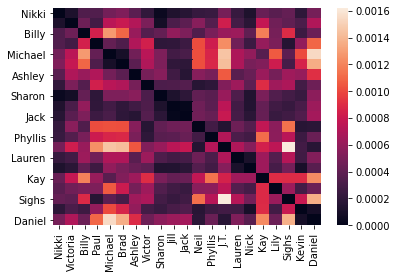

In [149]:
fig = plt.figure()
div = pandas.DataFrame(M, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

This is one example of how we can use topic models to analyse a network - what other data exploration can you come up with?  Maybe see what are the themes surrounding the top topics for each of the actors? You now have the infrastructure to explore the network and the topics. Gensim has a great set of Jupyter Notebooks which illustrate their methods and functions - https://github.com/RaRe-Technologies/gensim/tree/develop/docs/notebooks. The Auto Examples page also has a good variety of examples - https://radimrehurek.com/gensim/auto_examples/. 


### Dynamic Topic Modelling

Dynamic Topic Modelling is a time based topic model method introduced by David Blei and John Lafferty. It allows one to see topics evolve over a time annotated corpus. I would recommend first viewing the Dynamic Topic Model tutorial on Gensim (https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/ldaseqmodel.ipynb) to understand what exactly it's about. 

(An acknowledgement - Bhargav wrote the code for Gensim's Dynamic Topic Models back in 2016 as a Google Summer of Code student, and they're still using it as are thousands of others!)

To demonstrate it on a time based corpus, we will create a corpus from COHA.

In [150]:
corpora_address = "/Users/linghuiwu/uchicago/courseworks/soci40133/Content-Analysis-2020/week-5/COHA"

In [151]:
coha_texts = lucem_illud_2020.loadDavies(corpora_address, return_raw=True)

text_1940s_bsw.zip
text_1920s_gte.zip
text_1900s_mse.zip
text_1810s_kso.zip
text_2000s_scc.zip
text_1910s_jue.zip
text_1890s_jsq.zip
text_1870s_vuy.zip
text_1840s_nsq.zip
text_1860s_psi.zip
text_1950s_ndz.zip
text_1820s_jsi.zip
text_1980s_bkk.zip
text_1930s_bie.zip
text_1960s_xus.zip
text_1990s_bsj.zip
text_1830s_bsu.zip
text_1850s_jpr.zip
text_1970s_jfy.zip
text_1880s_azz.zip


In [152]:
list(coha_texts.keys())[0:5]

['mag_1940_148025.txt',
 'mag_1940_148026.txt',
 'mag_1940_148027.txt',
 'mag_1940_148028.txt',
 'mag_1940_148029.txt']

We'd have to approach this differently: note that while extracting the corpus we returned the raw texts (a new functionality in lucem_illud_2020), and the dictionary keys already contain some useful information: the year published, and the genre. neat! We can now create some corpora, organised by year and by genre.

In [153]:
coha_genres = {}
coha_years = {}

In [154]:
for article in coha_texts:
    genre, year, id_ = article.split("_")
    if genre not in coha_genres:
        coha_genres[genre] = []
    if genre in coha_genres:
        coha_genres[genre].append(coha_texts[article])
    
    if year not in coha_years:
        coha_years[year] = []
    if year in coha_years:
        coha_years[year].append(coha_texts[article])
    

In [155]:
coha_genres.keys()

dict_keys(['mag', 'nf', 'fic', 'news'])

In [156]:
coha_years.keys()

dict_keys(['1940', '1941', '1942', '1943', '1944', '1945', '1946', '1947', '1948', '1949', '1920', '1921', '1922', '1923', '1924', '1925', '1926', '1927', '1928', '1929', '1900', '1901', '1902', '1903', '1904', '1905', '1906', '1907', '1908', '1909', '1815', '1816', '1817', '1818', '1819', '1810', '1811', '1812', '1813', '1814', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '1910', '1911', '1912', '1913', '1914', '1915', '1916', '1917', '1918', '1919', '1890', '1891', '1892', '1893', '1894', '1895', '1896', '1897', '1898', '1899', '1870', '1871', '1872', '1873', '1874', '1875', '1876', '1877', '1878', '1879', '1840', '1841', '1842', '1843', '1844', '1845', '1846', '1847', '1848', '1849', '1860', '1861', '1862', '1863', '1864', '1865', '1866', '1867', '1868', '1869', '1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958', '1959', '1820', '1821', '1822', '1823', '1824', '1825', '1826', '1827', '1828', '1829', '1980', '1981', '1982', '1983

That's neat: we have 4 genres and 200 years. We have to now decide how many time slices we want. Let us see how the corpus is distributed.

If you went through the tutorial, you would notice how we would need to arrange the corpora year wise.
We also have to arrange the number of topics per year.

In [157]:
import collections

In [158]:
years = []
year_lens = []

In [159]:
for year_info in collections.OrderedDict(sorted(coha_years.items())):
    years.append(year_info)
    year_lens.append(len((coha_years[year_info])))

In [160]:
years[0], years[-1]

('1810', '2009')

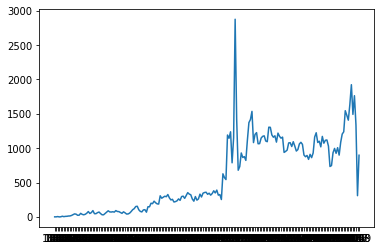

In [161]:
import matplotlib.pyplot as plt
plt.plot(years, year_lens);

The X axis isn't legible, but you can get the point: there are far less articles in the beginning, and then it grows. Maybe in our 5 time slices, we do: 1810-1880, 1881-1913, 1914-1950, 1950-1990, 1990-2009?
I use some historical intuition to use these time periods, you are encouraged to try your different time slices (for e.g, 20 10 year periods, 10 20 year periods, by total number of papers, etc)

In [162]:
all_texts_coha = []
docs_per_year = [0, 0, 0, 0, 0]
i = 0

In [163]:
len(sorted(coha_years))

200

In [165]:
# Comment out due to heavy computation

# for year_info in collections.OrderedDict(sorted(coha_years.items())):
#     large_files = 0
#     for article in coha_years[year_info]:
#         try:
#             if len(article[2]) < 1500000:
#                 all_texts_coha.append(lucem_illud_2020.normalizeTokens(article[2].decode("utf-8")))
#             if len(article[2]) >= 1500000:
#                 large_files += 1
#         except IndexError:
#             continue
#     # these numbers are the number of years in the 
#     if i < 70:
#         docs_per_year[0] += len(coha_years[year_info]) - large_files
#     if i >= 70 and i < 103:
#         docs_per_year[1] += len(coha_years[year_info]) - large_files
#     if i >= 103 and i < 140:
#         docs_per_year[2] += len(coha_years[year_info]) - large_files
#     if i >= 140 and i < 180:
#         docs_per_year[3] += len(coha_years[year_info]) - large_files
#     if i >= 180:
#         docs_per_year[4] += len(coha_years[year_info]) - large_files
#     i += 1

#### Smaller Corpora

The original size of the corpus is wayyy too big for our laptops. Let us demo this with a smaller size. You are welcome to try different sizes until you get the size you would like.
I am using a 100 documents per time slice for this example.

In [166]:
def choose_n(corpus, time_slices, nums=100):
    new_corpus = corpus[0:nums]
    for time_slice in time_slices[:-1]:
        new_corpus = new_corpus + corpus[time_slice:time_slice + nums]
    return new_corpus

Now, COHA also has some really large files, full books and the like: we're going to now split up really large files such that each of the documents are only 1000 tokens long. This function will return a split up document and the number of files it has been split into, so we can accordingly adjust the documents per time slice, which is important for Dynamic Topic Modelling to work.

In [167]:
def split_up(document, doc_size=1000):
    new_docs = [document[i:i + doc_size] for i in range(0, len(document), doc_size)]
    return(new_docs, len(new_docs))

In [168]:
small_corpus = choose_n(all_texts_coha, docs_per_year, nums=100)

In [169]:
final_corpus= []

In [170]:
docs_per_time_slice = [0, 0, 0, 0, 0]

I now use the split method to create my final corpus. Note that I hardcode values for the time slice to figure out the number of documets per time slice. Now I have a representative number of documents in each time slice. 

In [171]:
for i, article in enumerate(small_corpus):
    # identify time slice based on article number 
    if i < 100:
        time = 0
    if i > 100 and i <= 200:
        time = 1
    if i > 200 and i <= 300:
        time = 2
    if i > 300 and i <= 400:
        time = 3
    if i > 400 and i <= 500:
        time = 4
        
    if len(article) > 1000:
        split_docs, no_docs = split_up(article)
        for doc in split_docs:
            final_corpus.append(doc)
        docs_per_time_slice[time] += no_docs
    else:
        final_corpus.append(article)
        docs_per_time_slice[time] += 1
    # just a check if the counts are correctly added
    if np.sum(docs_per_time_slice) != len(final_corpus):
        print(np.sum(docs_per_time_slice), len(final_corpus))

In [172]:
dictionary = gensim.corpora.Dictionary(final_corpus)
dictionary

In [173]:
corpus = [dictionary.doc2bow(text) for text in final_corpus]

In [174]:
gensim.corpora.MmCorpus.serialize('coha.mm', corpus)
cohacorpus = gensim.corpora.MmCorpus('coha.mm')

In [175]:
from gensim.models import ldaseqmodel

In [177]:
# ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=docs_per_time_slice, num_topics=4)

In [178]:
# ldaseq.print_topics(time=0)[1]

In [180]:
# ldaseq.print_topics(time=4)[1]

What can you see from the analysis? I encourage you to explore the tutorial and see what else you can do with this dataset. In the above model I can see how the topic related to state evolves slowly, with the word president not previously there coming into the topic. I will now save this model and also upload it on GitHub so that you can see how it works. Note that the Dynamic Topic Model is a very time consuming algorithm: you might want to start a run overnight if you intend on using it in your analysis.

In [181]:
# ldaseq.save("ldaseqmodel")

In [183]:
# loaded_model = ldaseqmodel.LdaSeqModel.load("ldaseqmodel")



## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that use topic models and networks, or dynamic topic models on datasets relevant to your final project. You can also extend the analysis of the COHA or Soap datasets, if relevant to the comparison of data for your projects. (You could possibly use coha_genres dictionary to conduct analysis on topic evolution for a particular genre? What themes do you see evolving throughout these corpora?)

In [186]:
# Extract year information
year = [date[-4:] for date in speech["date"]]
speech["year"] = year
speech["year"].astype(int).describe()

count    1010.000000
mean     1922.786139
std        65.282248
min      1789.000000
25%      1867.000000
50%      1931.000000
75%      1978.750000
max      2020.000000
Name: year, dtype: float64

In [188]:
# Group by date and put text in a dictionary
speeches_year = {}
for index, speech in speech.iterrows():
    if not speech["year"] in speeches_year:
        speeches_year[speech["year"]] = [speech["script"]]
    if speech["year"] in speeches_year:
        speeches_year[speech["year"]].append(speech["script"])

In [189]:
# Count text for each year
years = []
year_lens = []
for year_info in collections.OrderedDict(sorted(speeches_year.items())):
    years.append(year_info)
    year_lens.append(len(speeches_year[year_info]))

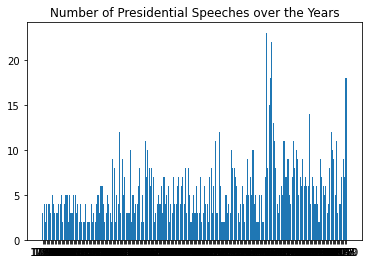

In [190]:
# Plot the number of speeches against year
plt.bar(years, year_lens)
plt.title("Number of Presidential Speeches over the Years")
plt.show()

In [191]:
# Split by half century

# - 1800
# 1801 - 1850
# 1851 - 1900
# 1901 - 1950
# 1951 - 2000
# 2001 - 2020

docs_per_half_century = [0 for i in range(6)]

for year_info in collections.OrderedDict(sorted(speeches_year.items())):
    if int(year_info) <= 1800:
        docs_per_half_century[0] += len(speeches_year[str(year_info)])   
    elif int(year_info) >= 1801 and int(year_info) <= 1850:
        docs_per_half_century[1] += len(speeches_year[str(year_info)])
    elif int(year_info) >= 1851 and int(year_info) <= 1900:
        docs_per_half_century[2] += len(speeches_year[str(year_info)])
    elif int(year_info) >= 1901 and int(year_info) <= 1950:
        docs_per_half_century[3] += len(speeches_year[str(year_info)])
    elif int(year_info) >= 1951 and int(year_info) <= 2000:
        docs_per_half_century[4] += len(speeches_year[str(year_info)])
    else:
        docs_per_half_century[5] += len(speeches_year[str(year_info)])

docs_per_half_century

[42, 203, 253, 240, 351, 147]

In [201]:
speeches_year_text = []
for year in speeches_year.keys():
    if int(year) >= 2000:
        for script in speeches_year[year]:
            speeches_year_text.append(script)

print(len(speeches_year_text))

149


In [202]:
# Tokenize the text
speeches_year_text_tokenized = []
for text in speeches_year_text:
    speeches_year_text_tokenized.append(
        lucem_illud_2020.normalizeTokens(lucem_illud_2020.word_tokenize(text))
    )

In [203]:
dictionary = gensim.corpora.Dictionary(speeches_year_text_tokenized)

In [204]:
corpus = [dictionary.doc2bow(text) for text in speeches_year_text_tokenized]

In [205]:
gensim.corpora.MmCorpus.serialize("speech.mm", corpus)
speech_corpus = gensim.corpora.MmCorpus("speech.mm")

In [207]:
docs_per_half_century = docs_per_half_century[3:]

In [208]:
ldaseq = ldaseqmodel.LdaSeqModel(corpus=speech_corpus, id2word=dictionary, time_slice=docs_per_half_century, num_topics=10)

In [209]:
ldaseq.print_topics(time=0)[1]

[('applause', 0.08024214949381554),
 ('people', 0.021758147086189946),
 ('know', 0.01979684385966835),
 ('go', 0.016571664738057327),
 ('want', 0.014511086488533319),
 ('laughter', 0.012851501693453353),
 ('great', 0.01266927944004555),
 ('have', 0.012375415483263404),
 ('right', 0.011813502225130917),
 ('say', 0.011322007477711208),
 ('get', 0.010656600711796877),
 ('country', 0.009806470905094572),
 ('like', 0.009629450387343499),
 ('come', 0.009469603826376958),
 ('year', 0.008678685441486726),
 ('be', 0.0073374979575047015),
 ('well', 0.007239224495101098),
 ('happen', 0.007186544783196952),
 ('way', 0.006986423622602949),
 ('win', 0.00698118764122886)]

In [222]:
# Take a look at the dynamic topic models
for time in range(3):
    print("Time {}".format(time))
    for topic in range(10):
        try:
            print("Topic {}".format(topic))
            print(pd.DataFrame(ldaseq.print_topics(time=time)[topic]))
        except IndexError:
            pass
    print("-" * 20)

Time 0
Topic 0
            0         1
0   president  0.028982
1          go  0.018058
2       think  0.015066
3           q  0.013832
4      people  0.012694
5        know  0.012570
6        have  0.011556
7        want  0.010924
8         say  0.010464
9       thank  0.010340
10       test  0.009161
11      state  0.008396
12       work  0.007670
13        lot  0.007233
14         mr  0.006986
15    country  0.006963
16      thing  0.006357
17       time  0.006356
18      great  0.006214
19       look  0.006007
Topic 1
           0         1
0   applause  0.080242
1     people  0.021758
2       know  0.019797
3         go  0.016572
4       want  0.014511
5   laughter  0.012852
6      great  0.012669
7       have  0.012375
8      right  0.011814
9        say  0.011322
10       get  0.010657
11   country  0.009806
12      like  0.009629
13      come  0.009470
14      year  0.008679
15        be  0.007337
16      well  0.007239
17    happen  0.007187
18       way  0.006986
19       win 

In [211]:
ldaseq.save("lda_seq_speeches_model")

In [213]:
loaded_model = ldaseqmodel.LdaSeqModel.load("lda_seq_speeches_model")
loaded_model

Since the dynamic topic modeling is super super super computationally intensive, I only consider presidential speeches over 2000 to 2020.

The results suggest that:

- The ten topic patterns are somewhat consistent over the two decades. For example, topic 3 is related to finance and economics and topic 6 focuses on American workers and the government.

- There is an evolution in the significance of each topic and there are also changes in the frequency of certain words used in a particular topic. For instance, in period 0, the word "finance" has a probability of 0.016155, while in period 3, the probability increased to 0.16381.